# How do Linear, Non-Linear, and Generative Models Differ in Addressing Semantic–Visual Gap in Zero-Shot Learning

#### Authors: Chilan Chan(1592844), Hongchao Lin(1796885) and Fanrui Zhang(1597969)

## Part 1 Data Preprocessing and loading the datasets

In [1]:
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as tvm
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet50_Weights 

device = "cuda" if torch.cuda.is_available() else "cpu"

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Preparing for training datasets 
##### To improve model robustness and mitigate overfitting, we use GaussianNoise, rotation randomly within 20 and change light(+/- 0.5)

In [2]:
#preprocessing: to get better results, we use GaussianNoise, rotation randomly within 20 and change light
#add GaussianNoise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'
#consider using resnet to preprocessing and making feature consturction
#we need change the oringinal picture into fitful size/standard        
IMG = 224
tfm = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.RandomRotation(degrees=20),           # random rotation（±20°）
    transforms.ColorJitter(brightness=0.5),          # change color/light (0.5~1.5)
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),         # Noise
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

### 1.2 Preparing for testing datasets and Loading
##### the reason to reload is that we don't add noise or do some augmentation to keep Image test sets match to the real Image to check the true result and analysis

In [5]:
# we need to reload the dataset to get the test_set without preprocessing(rotation, gaussian noise, and light changes)
tfm_test = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


### 1.3 Checking the image data sets
##### Checking the image dataset size and verified that no corrupted files were present/ or delete them

In [6]:
from PIL import Image
# open the file
#/Users/zhang/Desktop/slides/COMP90051/groupwork
img = Image.open("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages/antelope/antelope_10003.jpg")  
width, height = img.size
print(f"picture width: {width}, and height: {height}")

picture width: 1024, and height: 681


In [7]:
# at first using this code, get 2 bad files, then we decide to delete them directly
from PIL import Image
import os

root_dir = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
bad_files = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        try:
            img = Image.open(file_path)
            img.load()  
        except Exception:
            bad_files.append(file_path)

print(f"Images failed to load: {len(bad_files)}")

Images failed to load: 2


### 1.4 Preprocessing for Textual (Semantic) set
##### we do fault-tolerant file reading, the removal of blank lines and extra spaces, uppercase normalisation, regular-expression-based cleaning, and keyword-based extraction focused on title and description fields.

In [ ]:
import re
import os
import pandas as pd
from torchvision import datasets

# the path is just by the author
IMG_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
TXT_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses"


class_to_idx = datasets.ImageFolder(IMG_ROOT).class_to_idx  # {'antelope':0, ...}
idx_to_class = {v: k for k, v in class_to_idx.items()}


def read_title_and_desc_clean(p):
    title, desc = "", ""
    clean = lambda s: re.sub(r'[\+\-\|\_]+', '', s).strip()
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        lines = [line.strip() for line in f if line.strip()]

    for i, line in enumerate(lines):
        U = line.upper()
        if "TITLE" in U and i + 1 < len(lines):
            title = clean(lines[i + 1])
        if "DESCRIPTION" in U:
            buf = []
            for j in range(i + 1, len(lines)):
                if any(k in lines[j].upper() for k in ["TITLE","INFO","TAGS","PHOTOGRAPHER","LICENSE"]):
                    break
                buf.append(clean(lines[j]))
            desc = " ".join(buf).strip()
            break
    title = re.sub(r"<.*?>", "", title)
    desc  = re.sub(r"<.*?>", "", desc)
    return title, desc


rows = []
for cls in sorted(os.listdir(TXT_ROOT)):
    cls_dir = os.path.join(TXT_ROOT, cls)
    if not os.path.isdir(cls_dir):
        continue
    pieces = []
    for fname in sorted(os.listdir(cls_dir)):
        if fname.endswith(".txt"):
            t, d = read_title_and_desc_clean(os.path.join(cls_dir, fname))
            text = " ".join([t, d]).strip()
            if text:
                pieces.append(text)
    merged = " ".join(pieces)             
    rows.append({"class": cls, "text": merged, "n_txt": len(pieces)})


df = pd.DataFrame(rows)
df["label"] = df["class"].map(class_to_idx)
df = df.sort_values("label").reset_index(drop=True)
print("row number:", len(df))
print(df[["label","class","n_txt"]].head())


row number: 50
   label       class  n_txt
0      0    antelope   1046
1      1         bat    178
2      2      beaver    147
3      3  blue+whale    174
4      4      bobcat    627


In [9]:
#check
txt_path = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses/antelope/antelope_10021.txt"
title, desc = read_title_and_desc_clean(txt_path)
print("TITLE:", title)
print("DESCRIPTION:", desc[:200], "...")

TITLE: 
DESCRIPTION: You are free to use this photo  (including commercial use) under attribution to the author. If being used online please add a link to ujora.de Dieses Foto darf unter Angabe des Autors frei verwendet w ...


In [10]:
df.head()

,class,text,n_txt,label
0,antelope,"\And God said, Let the earth bring forth the l...",1046,0
1,bat,Found below the power lines at Hamilton Beach....,178,1
2,beaver,the local beavers on Christmas day 2007 (no de...,147,2
3,blue+whale,(no description) Free Fall breaching. (no desc...,174,3
4,bobcat,"One of the cubs walking in the enclosure, unde...",627,4


## Part 2 Feature Construction

In [3]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import has_file_allowed_extension, IMG_EXTENSIONS

def is_ok(p):
    b = os.path.basename(p)
    return (not b.startswith(".")) and has_file_allowed_extension(p, IMG_EXTENSIONS)

train = ImageFolder( 
    "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages",
     transform=tfm, is_valid_file=is_ok)
train_loader = DataLoader(train, batch_size=64, shuffle=False, num_workers=0)

In [12]:
#loading the data
test = datasets.ImageFolder("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages", 
                            transform=tfm_test, 
                            is_valid_file=lambda x: not x.startswith('.') and x.lower().endswith(('.jpg', '.jpeg', '.png'))
                           )
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)

### 2.1 using resnet to build X_train,y_train, X_test and y_test


In [14]:
#using resnet method to extract features, 
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Identity()     
resnet = resnet.to(device)
resnet.eval();

In [27]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(train_loader, desc="Extracting features"):
        try:
            feats = resnet(imgs.to(device))      # [batch, 2048]
            all_feats.append(feats.cpu())
            all_labels.append(labels)
        except Exception:
            continue





Extracting features: 100%|██████████| 584/584 [14:32<00:00,  1.49s/it]


In [ ]:

X_train = torch.cat(all_feats, dim=0)   # [N, 2048]
y = torch.cat(all_labels, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

Feature tensor shape: torch.Size([37322, 2048])
Number of labels: 37322


In [ ]:
#same process for X_test and y

In [30]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats1, all_labels1 = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Extracting features"):
        try:
            feats1 = resnet(imgs.to(device))      # [batch, 2048]
            all_feats1.append(feats1.cpu())
            all_labels1.append(labels)
        except Exception:
            continue

Extracting features: 100%|██████████| 584/584 [02:54<00:00,  3.35it/s]


In [ ]:

X_test = torch.cat(all_feats1, dim=0)   # [N, 2048]
y = torch.cat(all_labels1, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

Feature tensor shape: torch.Size([37322, 2048])
Number of labels: 37322


### 2.2 spliting the training set and testing set
#####  considering  cross validation(k=10) we divide X_train,y_train, X_test and y_test into 10 combination based on classes in y_train and y_test, to keep unseen data for train sets

In [33]:
import torch

X_train_parts, y_train_parts = [], []

for i in range(0, 50, 5):
    # same process but need change mask to proof unseen for train sets
    mask = (y < i) | (y >= i + 5)
    X_train_parts.append(X_train[mask])
    y_train_parts.append(y[mask])


(X_train_1, X_train_2, X_train_3, X_train_4, X_train_5,
 X_train_6, X_train_7, X_train_8, X_train_9, X_train_10) = X_train_parts

(y_train_1, y_train_2, y_train_3, y_train_4, y_train_5,
 y_train_6, y_train_7, y_train_8, y_train_9, y_train_10) = y_train_parts

# === check each train split's class distribution ===
for i in range(10):
    y_i = y_train_parts[i]
    uniq, counts = torch.unique(y_i, return_counts=True)
    uniq, counts = uniq.tolist(), counts.tolist()
    
    print(f"\nX_train_{i+1}.shape = {X_train_parts[i].shape}")
    print("distribution（class: count）:")
    for j in range(0, len(uniq), 10):
        line = ", ".join(f"{c}:{n}" for c, n in zip(uniq[j:j+10], counts[j:j+10]))
        print("   " + line)




X_train_1.shape = torch.Size([34896, 2048])
distribution（class: count）:
   5:895, 6:567, 7:728, 8:1028, 9:1338, 10:549, 11:1344, 12:946, 13:1038, 14:664
   15:1033, 16:874, 17:1202, 18:872, 19:852, 20:779, 21:684, 22:1645, 23:709, 24:291
   25:720, 26:1019, 27:100, 28:704, 29:185, 30:758, 31:728, 32:747, 33:713, 34:868
   35:1088, 36:512, 37:310, 38:696, 39:988, 40:1420, 41:500, 42:188, 43:291, 44:1200
   45:877, 46:215, 47:272, 48:589, 49:1170

X_train_2.shape = torch.Size([32766, 2048])
distribution（class: count）:
   0:1046, 1:383, 2:193, 3:174, 4:630, 10:549, 11:1344, 12:946, 13:1038, 14:664
   15:1033, 16:874, 17:1202, 18:872, 19:852, 20:779, 21:684, 22:1645, 23:709, 24:291
   25:720, 26:1019, 27:100, 28:704, 29:185, 30:758, 31:728, 32:747, 33:713, 34:868
   35:1088, 36:512, 37:310, 38:696, 39:988, 40:1420, 41:500, 42:188, 43:291, 44:1200
   45:877, 46:215, 47:272, 48:589, 49:1170

X_train_3.shape = torch.Size([32781, 2048])
distribution（class: count）:
   0:1046, 1:383, 2:193, 3:1

In [32]:
X_test_parts, y_parts = [], []

for i in range(0, 50, 5):  
    #for k = 10, we divide test set into 10 parts, and each parts have 5 unseen categories
    mask = (y >= i) & (y < i + 5)
    X_test_parts.append(X_test[mask])
    y_parts.append(y[mask])

(X_test_1, X_test_2, X_test_3, X_test_4, X_test_5,
 X_test_6, X_test_7, X_test_8, X_test_9, X_test_10) = X_test_parts

(y_test_1, y_test_2, y_test_3, y_test_4, y_test_5,
 y_test_6, y_test_7, y_test_8, y_test_9, y_test_10) = y_parts
# check
for i, x in enumerate(X_test_parts, 1):
    print(f"X_test_{i}.shape = {x.shape}, y range = {y_parts[i-1].min().item()}–{y_parts[i-1].max().item()}")



X_test_1.shape = torch.Size([2426, 2048]), y range = 0–4
X_test_2.shape = torch.Size([4556, 2048]), y range = 5–9
X_test_3.shape = torch.Size([4541, 2048]), y range = 10–14
X_test_4.shape = torch.Size([4833, 2048]), y range = 15–19
X_test_5.shape = torch.Size([4108, 2048]), y range = 20–24
X_test_6.shape = torch.Size([2728, 2048]), y range = 25–29
X_test_7.shape = torch.Size([3814, 2048]), y range = 30–34
X_test_8.shape = torch.Size([3594, 2048]), y range = 35–39
X_test_9.shape = torch.Size([3599, 2048]), y range = 40–44
X_test_10.shape = torch.Size([3123, 2048]), y range = 45–49


### 2.3 build txt set (as emb) by using Sentence-BERT

In [ ]:
# 0) installing
# pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch, numpy as np
import pandas as pd

# 1) model choice
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2" )  # only english


# 2) get text
texts = df["text"].fillna("").astype(str).tolist()
labels = df["label"].to_numpy()

# 3) embedding
emb = model.encode(
    texts,
    batch_size=64,
    convert_to_tensor=True,
    normalize_embeddings=True,   
    show_progress_bar=True
)   # shape: [N, D]，

print(emb.shape, emb.dtype)    


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:27<00:00, 27.36s/it]

torch.Size([50, 768]) torch.float32


### 2.4 show the whole data name and shape

In [14]:
print(emb.shape, 
X_train_1.shape ,
X_test_1.shape, 
y_train_1.shape ,
y_test_1.shape) 

torch.Size([50, 768]) torch.Size([34868, 2048]) torch.Size([2426, 2048]) torch.Size([34868]) torch.Size([2426])


## Part 3 Modeling(by three algorithm)

### 3.1 ridge
##### we use lamda = (0.1, 1.0, 10,100) as hyperparmeters 


========== Outer Fold 01 ==========
Inner 3-fold mean accuracy by λ:
  λ=0.1   -> 0.3014
  λ=1.0   -> 0.2992
  λ=10.0  -> 0.3040
  λ=100.0 -> 0.2828
Chosen λ: 10.0  | inner-CV time: 4.67s
Accuracy: 0.4225
Macro P/R/F1: 0.5572 / 0.5984 / 0.4476
RMSE: 0.037637  MAE: 0.028922
Outer train+eval time: 0.06s
Confusion Matrix (rows=true, cols=pred):
tensor([[ 23,   0,  98,   0, 925],
        [120,  37, 132,  19,  75],
        [  1,   0, 173,  17,   2],
        [  0,   0,   1, 173,   0],
        [  1,   0,  10,   0, 619]])
Learning-curve acc by frac: 0.1:0.406  0.2:0.409  0.4:0.411  0.6:0.417  0.8:0.421  1.0:0.423

========== Outer Fold 02 ==========
Inner 3-fold mean accuracy by λ:
  λ=0.1   -> 0.2567
  λ=1.0   -> 0.2593
  λ=10.0  -> 0.2650
  λ=100.0 -> 0.2523
Chosen λ: 10.0  | inner-CV time: 4.46s
Accuracy: 0.6982
Macro P/R/F1: 0.7523 / 0.6827 / 0.6813
RMSE: 0.031899  MAE: 0.024491
Outer train+eval time: 0.10s
Confusion Matrix (rows=true, cols=pred):
tensor([[ 345,   93,    0,  383,   74],
 

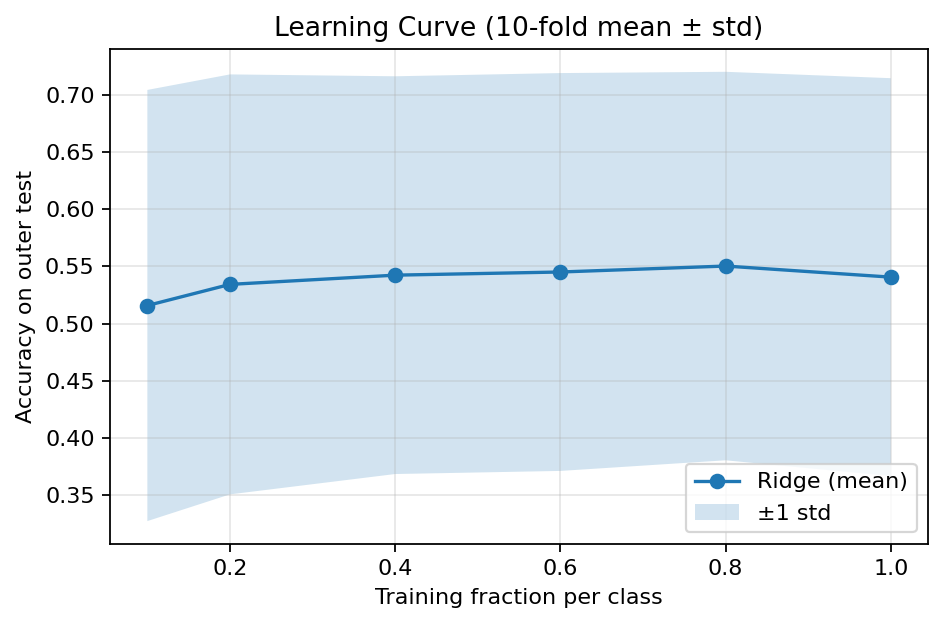

In [25]:
import time, math
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def l2norm(X):
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def uniq_sorted_cpu(y):  
    return sorted(list(set(y.detach().cpu().numpy().tolist())))

def fit_ridge(Xtr, Ytr, lam):
    d = Xtr.size(1)
    XtX = Xtr.T @ Xtr
    XtY = Xtr.T @ Ytr
    I   = torch.eye(d, device=Xtr.device)
    return torch.linalg.solve(XtX + lam * I, XtY)  # [feat, emb]

@torch.inference_mode()
def predict_labels(X, W, E, class_ids):
    Z = l2norm(X @ W)                # [N, D_txt]
    P = l2norm(E[class_ids])         # [U, D_txt]
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

def accuracy_manual(y_true, y_pred):
    return sum(1 for a,b in zip(y_true, y_pred) if a == b) / len(y_true)

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels); idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp>0, tp/(tp+fp), torch.zeros_like(tp))
    rec_i  = torch.where(tp+fn>0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+rec_i>0, 2*prec_i*rec_i/(prec_i+rec_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(rec_i.mean()), float(f1_i.mean())

def embedding_errors(Z_pred, y_true, E):  # RMSE/MAE in embedding space
    tgt = l2norm(E[torch.as_tensor(y_true, device=Z_pred.device)])
    diff = (Z_pred - tgt).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return rmse, mae

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_val = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr  = ~mask_val
    return X[mask_tr], y[mask_tr], X[mask_val], y[mask_val]


def stratified_take_by_frac(X, y, frac, min_take=1):
    cls = uniq_sorted_cpu(y)
    idxs = []
    for c in cls:
        pos = torch.where(y == c)[0]
        k = max(min_take, math.ceil(pos.numel() * frac))
        take = pos[torch.randperm(pos.numel(), device=y.device)[:k]]
        idxs.append(take)
    idxs = torch.cat(idxs, dim=0)
    return X.index_select(0, idxs), y.index_select(0, idxs)


def inner_cv_choose_lambda(Xtr_full, ytr_full, E, lam_grid=(0.1, 1.0, 10.0, 100.0)):
    seen = uniq_sorted_cpu(ytr_full)
    assert len(seen) == 45, f"expect 45 seen classes, got {len(seen)}"
    folds = [seen[0:15], seen[15:30], seen[30:45]]

    lambda_means = {}
    t0 = time.perf_counter()
    for lam in lam_grid:
        accs = []
        for val_cls in folds:
            Xtr, ytr, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_cls)
            W = fit_ridge(l2norm(Xtr), E[ytr], lam)
            y_pred, _ = predict_labels(l2norm(Xva), W, E, sorted(val_cls))
            accs.append(accuracy_manual(yva.cpu().numpy().tolist(), y_pred.tolist()))
        lambda_means[float(lam)] = float(np.mean(accs))
    t1 = time.perf_counter()
    time_sec = t1 - t0

    best_lam = min(
        lam_grid,
        key=lambda l: (-lambda_means[float(l)], float(l))
    )
    return float(best_lam), lambda_means, time_sec

def learning_curve_on_outer_fold(Xtr, ytr, Xte, yte, E, best_lambda,
                                 fractions=(0.1, 0.2, 0.4, 0.6, 0.8, 1.0)):
    accs, times = [], []
    for f in fractions:
        t0 = time.perf_counter()
        Xsub, ysub = stratified_take_by_frac(Xtr, ytr, f)
        W = fit_ridge(l2norm(Xsub), E[ysub], best_lambda)
        y_pred, _ = predict_labels(l2norm(Xte), W, E, uniq_sorted_cpu(torch.as_tensor(yte)))
        accs.append(accuracy_manual(yte, y_pred.tolist()))
        times.append(time.perf_counter() - t0)
    return np.array(accs, float), np.array(times, float)


E_all = l2norm(emb.float().to(device))

outer_rows = []               
inner_table_acc = {0.1: [], 1.0: [], 10.0: [], 100.0: []}
inner_times = []          
outer_times = []               

fractions = (0.1, 0.2, 0.4, 0.6, 0.8, 1.0)
lc_all_acc = []              
lc_all_time = []               

for i in range(1, 10+1):
    print(f"\n========== Outer Fold {i:02d} ==========")

    Xtr = globals()[f"X_train_{i}"].float().to(device)
    ytr = globals()[f"y_train_{i}"].long().to(device)
    Xte = globals()[f"X_test_{i}"].float().to(device)
    yte = globals()[f"y_test_{i}"].long().cpu().numpy().tolist()


    best_lam, lam_means, t_sec = inner_cv_choose_lambda(Xtr, ytr, E_all, lam_grid=(0.1, 1.0, 10.0, 100.0))
    inner_times.append(t_sec)
    print("Inner 3-fold mean accuracy by λ:")
    for lam in (0.1, 1.0, 10.0, 100.0):
        m = lam_means[lam]; inner_table_acc[lam].append(m)
        print(f"  λ={lam:<5} -> {m:.4f}")
    print(f"Chosen λ: {best_lam}  | inner-CV time: {t_sec:.2f}s")


    t0 = time.perf_counter()
    W = fit_ridge(l2norm(Xtr), E_all[ytr], best_lam)
    unseen_ids = uniq_sorted_cpu(torch.as_tensor(yte))
    y_pred, Z_te = predict_labels(l2norm(Xte), W, E_all, unseen_ids)

    acc = accuracy_manual(yte, y_pred.tolist())
    cm  = confusion_matrix_manual(yte, y_pred.tolist(), unseen_ids)
    mp, mr, mf1 = macro_prf_from_cm(cm)
    rmse, mae = embedding_errors(Z_te, yte, E_all)
    t1 = time.perf_counter(); outer_times.append(t1 - t0)


    print(f"Accuracy: {acc:.4f}")
    print(f"Macro P/R/F1: {mp:.4f} / {mr:.4f} / {mf1:.4f}")
    print(f"RMSE: {rmse:.6f}  MAE: {mae:.6f}")
    print(f"Outer train+eval time: {outer_times[-1]:.2f}s")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    np.save(f"cm_fold{i:02d}.npy", cm.cpu().numpy())  

    outer_rows.append({
        "fold": i, "lambda": best_lam,
        "acc": acc, "macro_p": mp, "macro_r": mr, "macro_f1": mf1,
        "rmse": rmse, "mae": mae
    })


    lc_acc, lc_time = learning_curve_on_outer_fold(Xtr, ytr, Xte, yte, E_all, best_lam, fractions=fractions)
    lc_all_acc.append(lc_acc); lc_all_time.append(lc_time)
    print("Learning-curve acc by frac:", "  ".join([f"{f:.1f}:{a:.3f}" for f,a in zip(fractions, lc_acc)]))


def mean_std(vals):
    vals = np.array(vals, dtype=float)
    return float(vals.mean()), float(vals.std(ddof=1))  # sample std

acc_mean,   acc_std   = mean_std([r["acc"] for r in outer_rows])
mp_mean,    mp_std    = mean_std([r["macro_p"] for r in outer_rows])
mr_mean,    mr_std    = mean_std([r["macro_r"] for r in outer_rows])
mf1_mean,   mf1_std   = mean_std([r["macro_f1"] for r in outer_rows])
rmse_mean,  rmse_std  = mean_std([r["rmse"] for r in outer_rows])
mae_mean,   mae_std   = mean_std([r["mae"] for r in outer_rows])

print("\n========== 10-Fold Overall Summary (Ridge) ==========")
print(f"Accuracy : {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Macro P  : {mp_mean:.4f} ± {mp_std:.4f}")
print(f"Macro R  : {mr_mean:.4f} ± {mr_std:.4f}")
print(f"Macro F1 : {mf1_mean:.4f} ± {mf1_std:.4f}")
print(f"RMSE     : {rmse_mean:.6f} ± {rmse_std:.6f}")
print(f"MAE      : {mae_mean:.6f} ± {mae_std:.6f}")

print("\n========== Inner-CV Mean Accuracy by λ (averaged over 10 outer folds) ==========")
for lam in (0.1, 1.0, 10.0, 100.0):
    m, s = mean_std(inner_table_acc[lam])
    print(f"λ={lam:<5}  mean_acc={m:.4f} ± {s:.4f}  (n={len(inner_table_acc[lam])})")

print("\n========== Timing ==========")
print(f"Inner-CV time per fold (mean ± std): {np.mean(inner_times):.2f}s ± {np.std(inner_times, ddof=1):.2f}s")
print(f"Outer train+eval time per fold (mean ± std): {np.mean(outer_times):.2f}s ± {np.std(outer_times, ddof=1):.2f}s")


lc_all_acc = np.stack(lc_all_acc, axis=0)   # [10, F]
mean_curve = lc_all_acc.mean(axis=0)
std_curve  = lc_all_acc.std(axis=0, ddof=1)

plt.figure(figsize=(6,4), dpi=160)
xs = np.array(fractions)
plt.plot(xs, mean_curve, marker='o', label='Ridge (mean)')
plt.fill_between(xs, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2, label='±1 std')
plt.xlabel('Training fraction per class')
plt.ylabel('Accuracy on outer test')
plt.title('Learning Curve (10-fold mean ± std)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 3.2 MLP(with reg and earlystop)
##### for hyperparmeters we consider dropout_p = (0.0,0.4,0.6); hid_dim = (256,512,1024) and using k=3 inner cross validation to choose the best hyperparmeters.


========== Outer Fold 01 ==========
Inner 3-fold mean accuracy by (p, hidden):
  p=0.0, h= 256 -> 0.3419
  p=0.0, h= 512 -> 0.3351
  p=0.0, h=1024 -> 0.3405
  p=0.4, h= 256 -> 0.3378
  p=0.4, h= 512 -> 0.3463
  p=0.4, h=1024 -> 0.3415
  p=0.6, h= 256 -> 0.3344
  p=0.6, h= 512 -> 0.3290
  p=0.6, h=1024 -> 0.3284
Chosen: dropout_p=0.4, hidden_dim=512 | inner-CV time: 91.22s
Accuracy: 0.4196
Macro P/R/F1: 0.5736 / 0.5799 / 0.4839
RMSE: 0.038116  MAE: 0.029428
Outer train+eval time: 13.71s
Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):
tensor([[ 36,   0, 951,   0,  59],
        [132, 102,  61,  31,  57],
        [ 35,   0, 133,  11,  14],
        [  0,   0,   0, 174,   0],
        [ 37,   1,  17,   2, 573]])
Learning-curve acc by frac: 0.1:0.424  0.2:0.440  0.4:0.421  0.6:0.433  0.8:0.410  1.0:0.428

========== Outer Fold 02 ==========
Inner 3-fold mean accuracy by (p, hidden):
  p=0.0, h= 256 -> 0.3008
  p=0.0, h= 512 -> 0.3017
  p=0.0, h=1024 -> 0.2964
  p=0.4, h= 25

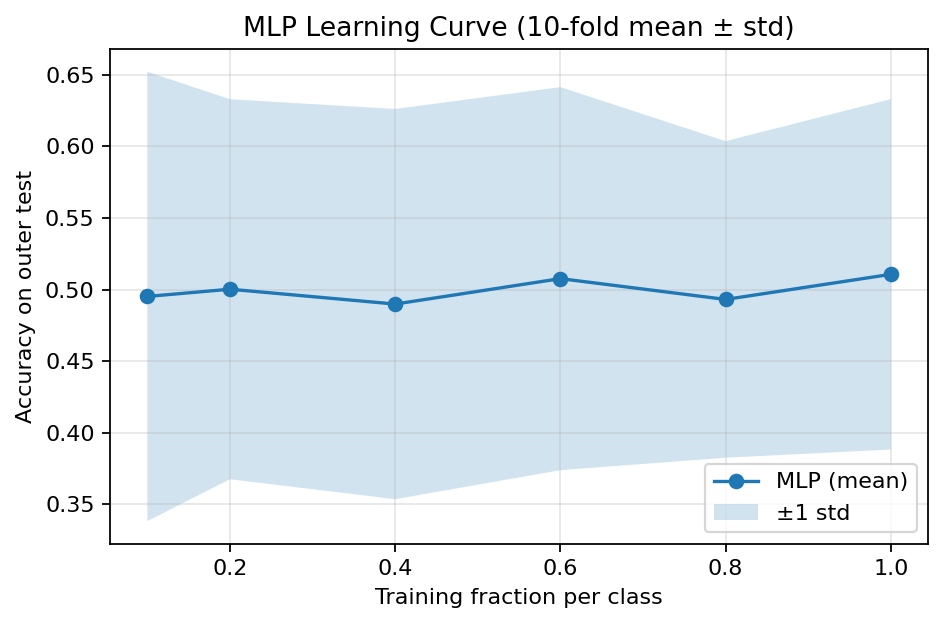

In [27]:
import time, math
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def l2norm(X):
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def uniq_sorted_cpu(y):
    return sorted(list(set(y.detach().cpu().numpy().tolist())))

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels); idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def accuracy_manual(y_true, y_pred):
    return sum(1 for a,b in zip(y_true, y_pred) if a == b) / len(y_true)

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp>0, tp/(tp+fp), torch.zeros_like(tp))
    rec_i  = torch.where(tp+fn>0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+rec_i>0, 2*prec_i*rec_i/(prec_i+rec_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(rec_i.mean()), float(f1_i.mean())

def embedding_errors(Z_pred, y_true, E):  # RMSE/MAE in embedding space
    tgt = l2norm(E[torch.as_tensor(y_true, device=Z_pred.device)])
    diff = (Z_pred - tgt).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return rmse, mae

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]


def stratified_take_by_frac(X, y, frac, min_take=1):
    cls = uniq_sorted_cpu(y)
    idxs = []
    for c in cls:
        pos = torch.where(y == c)[0]
        k = max(min_take, math.ceil(pos.numel() * frac))
        take = pos[torch.randperm(pos.numel(), device=y.device)[:k]]
        idxs.append(take)
    idxs = torch.cat(idxs, dim=0)
    return X.index_select(0, idxs), y.index_select(0, idxs)

@torch.inference_mode()
def predict_labels_from_model(model, X, E, class_ids):
    Z = l2norm(model(l2norm(X)))
    P = l2norm(E[class_ids])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

class Img2Txt(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=512, dropout_p=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

def inner_cv_choose_hyper(Xtr_full, ytr_full, E,
                          p_grid=(0.0, 0.4, 0.6),
                          h_grid=(256, 512, 1024),
                          lr=1e-3, weight_decay=5e-3,
                          patience=5, max_epoch=30, bs=256):
    seen = uniq_sorted_cpu(ytr_full)
    assert len(seen) == 45, f"expect 45 seen classes, got {len(seen)}"
    folds = [seen[0:15], seen[15:30], seen[30:45]]

    grid_scores = {}  # (p,h) -> mean_acc
    t0 = time.perf_counter()

    for p in p_grid:
        for h in h_grid:
            fold_accs = []
            for val_classes in folds:
                Xtr, ytr, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_classes)
                tr_dl = DataLoader(TensorDataset(l2norm(Xtr), ytr), batch_size=bs, shuffle=True)
                va_dl = DataLoader(TensorDataset(l2norm(Xva), yva), batch_size=512, shuffle=False)

                model = Img2Txt(Xtr.size(1), E.size(1), hidden_dim=h, dropout_p=p).to(device)
                opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
                mse = nn.MSELoss()

                best_acc, best_state, wait = 0.0, None, 0
                for ep in range(max_epoch):
                    model.train()
                    for xb, yb in tr_dl:
                        xb = xb.to(device); yb = yb.to(device)
                        loss = mse(model(xb), E[yb])
                        opt.zero_grad(); loss.backward(); opt.step()

        
                    model.eval()
                    cls = sorted(val_classes)
                    correct = total = 0
                    with torch.no_grad():
                        for xb, yb in va_dl:
                            xb = xb.to(device); yb = yb.to(device)
                            pred, _ = predict_labels_from_model(model, xb, E, cls)
                            correct += int((torch.as_tensor(pred, device=yb.device) == yb).sum().item())
                            total   += int(yb.numel())
                    val_acc = correct / max(1, total)

                    if val_acc > best_acc:
                        best_acc = val_acc
                        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
                        wait = 0
                    else:
                        wait += 1
                        if wait >= patience:
                            break
                fold_accs.append(best_acc)
            grid_scores[(float(p), int(h))] = float(np.mean(fold_accs))

    t1 = time.perf_counter()
    inner_time = t1 - t0

    best_p, best_h = min(
        grid_scores.keys(),
        key=lambda ph: (-grid_scores[ph], ph[1], ph[0])
    )
    return (best_p, best_h), grid_scores, inner_time

def learning_curve_on_outer_fold(Xtr, ytr, Xte, yte, E, p, h,
                                 lr=1e-3, weight_decay=5e-3,
                                 patience=5, max_epoch=30, bs=256,
                                 fractions=(0.1, 0.2, 0.4, 0.6, 0.8, 1.0)):
    accs, times = [], []
    mse = nn.MSELoss()
    in_dim, out_dim = Xtr.size(1), E.size(1)

    for f in fractions:
        t0 = time.perf_counter()
        Xsub, ysub = stratified_take_by_frac(Xtr, ytr, f)
        tr_dl = DataLoader(TensorDataset(l2norm(Xsub), ysub), batch_size=bs, shuffle=True)

        model = Img2Txt(in_dim, out_dim, hidden_dim=h, dropout_p=p).to(device)
        opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_loss, best_state, wait = 1e9, None, 0
        for ep in range(max_epoch):
            model.train()
            running = 0.0
            for xb, yb in tr_dl:
                xb = xb.to(device); yb = yb.to(device)
                loss = mse(model(xb), E[yb])
                opt.zero_grad(); loss.backward(); opt.step()
                running += float(loss.item()) * yb.size(0)
            avg = running / len(tr_dl.dataset)
            if avg < best_loss:
                best_loss = avg; best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
                if wait >= patience: break
        model.load_state_dict({k:v.to(device) for k,v in best_state.items()})
        model.eval()

        cls_unseen = uniq_sorted_cpu(torch.as_tensor(yte))
        y_pred, _ = predict_labels_from_model(model, Xte, E, cls_unseen)
        accs.append(accuracy_manual(yte, y_pred.tolist()))
        times.append(time.perf_counter() - t0)

    return np.array(accs, float), np.array(times, float)


E_all = l2norm(emb.float().to(device))

outer_rows = []                      
inner_times = []                   
outer_times = []                     
grid_log = []                       
fractions = (0.1, 0.2, 0.4, 0.6, 0.8, 1.0)
lc_all_acc = []                 
lc_all_time = []    
chosen_list = []                 

for i in range(1, 10+1):
    print(f"\n========== Outer Fold {i:02d} ==========")
    Xtr = globals()[f"X_train_{i}"].float().to(device)
    ytr = globals()[f"y_train_{i}"].long().to(device)
    Xte = globals()[f"X_test_{i}"].float().to(device)
    yte = globals()[f"y_test_{i}"].long().to(device)
    yte_np = yte.cpu().numpy().tolist()

    
    (best_p, best_h), grid_scores, t_sec = inner_cv_choose_hyper(
        Xtr, ytr, E_all,
        p_grid=(0.0, 0.4, 0.6), h_grid=(256, 512, 1024),
        lr=1e-3, weight_decay=5e-3, patience=5, max_epoch=30, bs=256
    )
    inner_times.append(t_sec); chosen_list.append((best_p, best_h))
    print("Inner 3-fold mean accuracy by (p, hidden):")

    for p in (0.0, 0.4, 0.6):
        for h in (256, 512, 1024):
            m = grid_scores[(p, h)]
            grid_log.append({"fold": i, "p": p, "hidden": h, "mean_acc": m})
            print(f"  p={p:.1f}, h={h:4d} -> {m:.4f}")
    print(f"Chosen: dropout_p={best_p}, hidden_dim={best_h} | inner-CV time: {t_sec:.2f}s")

    # ---- 外层最终训练 + 测试 ----
    in_dim, out_dim = Xtr.size(1), E_all.size(1)
    model = Img2Txt(in_dim, out_dim, hidden_dim=best_h, dropout_p=best_p).to(device)
    opt   = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
    mse   = nn.MSELoss()
    tr_dl_full = DataLoader(TensorDataset(l2norm(Xtr), ytr), batch_size=256, shuffle=True)

    t0 = time.perf_counter()
    best_state, wait, best_loss = None, 0, 1e9
    for ep in range(30):
        model.train()
        running = 0.0
        for xb, yb in tr_dl_full:
            xb = xb.to(device); yb = yb.to(device)
            loss = mse(model(xb), E_all[yb])
            opt.zero_grad(); loss.backward(); opt.step()
            running += float(loss.item()) * yb.size(0)
        avg = running / len(tr_dl_full.dataset)
        if avg < best_loss:
            best_loss = avg
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= 5: break
    model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
    model.eval()

    cls_unseen = uniq_sorted_cpu(yte)
    y_pred, Z_te = predict_labels_from_model(model, Xte, E_all, cls_unseen)
    acc = accuracy_manual(yte_np, y_pred.tolist())
    cm  = confusion_matrix_manual(yte_np, y_pred.tolist(), cls_unseen)
    mp, mr, mf1 = macro_prf_from_cm(cm)
    rmse, mae = embedding_errors(Z_te, yte_np, E_all)
    t1 = time.perf_counter(); outer_times.append(t1 - t0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro P/R/F1: {mp:.4f} / {mr:.4f} / {mf1:.4f}")
    print(f"RMSE: {rmse:.6f}  MAE: {mae:.6f}")
    print(f"Outer train+eval time: {outer_times[-1]:.2f}s")
    print("Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):")
    print(cm)
    np.save(f"mlp_cm_fold{i:02d}.npy", cm.cpu().numpy())  # 可注释掉

    outer_rows.append({
        "fold": i, "p": best_p, "hidden": best_h,
        "acc": acc, "macro_p": mp, "macro_r": mr, "macro_f1": mf1,
        "rmse": rmse, "mae": mae
    })

 
    lc_acc, lc_time = learning_curve_on_outer_fold(
        Xtr, ytr, Xte, yte_np, E_all, best_p, best_h,
        lr=1e-3, weight_decay=5e-3, patience=5, max_epoch=30, bs=256,
        fractions=fractions
    )
    lc_all_acc.append(lc_acc); lc_all_time.append(lc_time)
    print("Learning-curve acc by frac:", "  ".join([f"{f:.1f}:{a:.3f}" for f,a in zip(fractions, lc_acc)]))

def mean_std(vals):
    vals = np.array(vals, dtype=float)
    return float(vals.mean()), float(vals.std(ddof=1))  

acc_mean,   acc_std   = mean_std([r["acc"] for r in outer_rows])
mp_mean,    mp_std    = mean_std([r["macro_p"] for r in outer_rows])
mr_mean,    mr_std    = mean_std([r["macro_r"] for r in outer_rows])
mf1_mean,   mf1_std   = mean_std([r["macro_f1"] for r in outer_rows])
rmse_mean,  rmse_std  = mean_std([r["rmse"] for r in outer_rows])
mae_mean,   mae_std   = mean_std([r["mae"] for r in outer_rows])

print("\n========== 10-Fold Overall Summary (MLP) ==========")
print("Chosen (dropout_p, hidden) per fold:", chosen_list)
print(f"Accuracy : {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Macro P  : {mp_mean:.4f} ± {mp_std:.4f}")
print(f"Macro R  : {mr_mean:.4f} ± {mr_std:.4f}")
print(f"Macro F1 : {mf1_mean:.4f} ± {mf1_std:.4f}")
print(f"RMSE     : {rmse_mean:.6f} ± {rmse_std:.6f}")
print(f"MAE      : {mae_mean:.6f} ± {mae_std:.6f}")

print("\n========== Timing ==========")
print(f"Inner-CV time per outer fold (mean ± std): {np.mean(inner_times):.2f}s ± {np.std(inner_times, ddof=1):.2f}s")
print(f"Outer train+eval time per fold (mean ± std): {np.mean(outer_times):.2f}s ± {np.std(outer_times, ddof=1):.2f}s")


lc_all_acc = np.stack(lc_all_acc, axis=0)   # [10, F]
mean_curve = lc_all_acc.mean(axis=0)
std_curve  = lc_all_acc.std(axis=0, ddof=1)

plt.figure(figsize=(6,4), dpi=160)
xs = np.array(fractions, float)
plt.plot(xs, mean_curve, marker='o', label='MLP (mean)')
plt.fill_between(xs, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2, label='±1 std')
plt.xlabel('Training fraction per class')
plt.ylabel('Accuracy on outer test')
plt.title('MLP Learning Curve (10-fold mean ± std)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
# plt.savefig("mlp_learning_curve.png", bbox_inches="tight") 
plt.show()


### 3.3 F-CLAWGAN
##### hyperparmeters about lamda = (0.1,1.0,10), we found it's difficult to decide but 1.0 and 0.1 occurs a little more, then we change some details to build a new process to choose best hyperparmeters from lamda = (0.1, 0.3, 1.0,3 .0), the details and the result found by F_C_lamda.ipynb

In [18]:

import functools, builtins
print = functools.partial(builtins.print, flush=True)

import torch, numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
torch.manual_seed(42); torch.cuda.manual_seed_all(42)
print(">>> Script loaded. Device:", device)


def l2norm(X):
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def unique_sorted_cpu(y_tensor):
    return sorted(list(set(y_tensor.detach().cpu().numpy().tolist())))

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_val = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr  = ~mask_val
    return X[mask_tr], y[mask_tr], X[mask_val], y[mask_val]

def accuracy_manual(y_true, y_pred):
    return sum(1 for a,b in zip(y_true, y_pred) if a == b) / len(y_true)

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels); idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag(); fp = cm.sum(0) - tp; fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp>0, tp/(tp+fp), torch.zeros_like(tp))
    reca_i = torch.where(tp+fn>0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+reca_i>0, 2*prec_i*reca_i/(prec_i+reca_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(reca_i.mean()), float(f1_i.mean())

def rmse_mae_visual(X_real, y_pred, gen_means_dict):
    diffs = []
    for xr, c in zip(X_real, y_pred):
        mu = gen_means_dict[int(c)]
        diffs.append((xr - mu).detach().cpu().numpy())
    diffs = np.stack(diffs, 0)
    mse = float((diffs**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diffs).mean())
    return rmse, mae


class Generator(nn.Module):
    def __init__(self, z_dim, sem_dim, feat_dim=2048, hidden=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + sem_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, feat_dim),
        )
    def forward(self, z, e):
        out = self.net(torch.cat([z, e], dim=1))
        return l2norm(out)  

class Critic(nn.Module):
    def __init__(self, sem_dim, feat_dim=2048, hidden=1024, n_cls=None):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Linear(feat_dim + sem_dim, hidden),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.critic = nn.Linear(hidden, 1)
        self.aux = nn.Linear(hidden, n_cls) if n_cls else None
    def forward(self, x, e):
        h = self.feat(torch.cat([x, e], dim=1))
        s = self.critic(h)
        p = self.aux(h) if self.aux else None
        return s, p

class LinearClassifier(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)
    def forward(self, x): return self.fc(x)


def grad_penalty(critic_func, real_x, fake_x, e, gp_lambda=10.0):
    bsz = real_x.size(0)
    eps = torch.rand(bsz, 1, device=real_x.device)
    inter = eps * real_x + (1 - eps) * fake_x
    inter.requires_grad_(True)
    out = critic_func(inter, e)
    grad = torch.autograd.grad(
        outputs=out,
        inputs=inter,
        grad_outputs=torch.ones_like(out),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_norm = grad.view(bsz, -1).norm(2, dim=1)
    return gp_lambda * ((grad_norm - 1.0) ** 2).mean()

#training
def train_fclswgan_on_seen(Xtr, ytr, E, train_classes,
                           lambda_cls=1.0, z_dim=100, n_critic=5, gp_lambda=10.0,
                           lr_g=1e-4, lr_d=4e-4, batch_size=256, epochs=30,
                           log_tag=""):
    feat_dim = Xtr.size(1); sem_dim = E.size(1)
    mask = torch.tensor([int(int(t.item()) in set(train_classes)) for t in ytr],
                        device=ytr.device, dtype=torch.bool)
    Xs, Ys = Xtr[mask], ytr[mask]
    loader = DataLoader(TensorDataset(Xs, Ys), batch_size=batch_size, shuffle=True, drop_last=True)

    G = Generator(z_dim, sem_dim, feat_dim).to(device)
    D = Critic(sem_dim, feat_dim, n_cls=len(train_classes)).to(device)

    optG = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optD = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.9))
    ce   = nn.CrossEntropyLoss(label_smoothing=0.05)
    cls2idx = {c:i for i,c in enumerate(sorted(train_classes))}

    for ep in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            eb = E[yb]; bsz = xb.size(0)
            y_idx = torch.tensor([cls2idx[int(t.item())] for t in yb], device=device)

            # ----- Train D -----
            for _ in range(n_critic):
                z = torch.randn(bsz, z_dim, device=device)
                xf = G(z, eb).detach()
                sr, pr = D(xb, eb)
                sf, pf = D(xf, eb)
                loss_D = -(sr.mean() - sf.mean()) \
                         + grad_penalty(lambda a,b: D(a,b)[0], xb, xf, eb, gp_lambda) \
                         + lambda_cls * ce(pr, y_idx)
                optD.zero_grad(); loss_D.backward(); optD.step()

            # ----- Train G -----
            z = torch.randn(bsz, z_dim, device=device)
            xf = G(z, eb)
            sf, pf = D(xf, eb)
            loss_G = -sf.mean() + lambda_cls * ce(pf, y_idx)
            optG.zero_grad(); loss_G.backward(); optG.step()

        if (ep+1) % 5 == 0 or ep == 0:
            print(f"    [G/D]{log_tag} epoch {ep+1}/{epochs} done")
    return G, None

# ---------- generate unseen features ----------
@torch.inference_mode()
def synthesize_features(G, E, class_ids, n_gen=400, z_dim=100):
    feats, labels = [], []
    for c in class_ids:
        e = E[torch.tensor([c], device=device)].repeat(n_gen, 1)
        z = torch.randn(n_gen, z_dim, device=device)
        feats.append(G(z, e))
        labels += [c]*n_gen
    return torch.cat(feats, 0), torch.tensor(labels, device=device)

# ---------- linear classifier ----------
def train_linear_classifier(X, y, class_ids, lr=1e-4, epochs=30, bs=512):
    cls2idx = {c:i for i,c in enumerate(sorted(class_ids))}
    y_idx = torch.tensor([cls2idx[int(t.item())] for t in y], device=device)
    loader = DataLoader(TensorDataset(X, y_idx), batch_size=bs, shuffle=True)
    C = LinearClassifier(X.size(1), len(class_ids)).to(device)
    opt = optim.Adam(C.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss(label_smoothing=0.05)
    for ep in range(epochs):
        for xb, yb in loader:
            loss = ce(C(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()
        if (ep+1) % 10 == 0 or ep == 0:
            print(f"    [CLS] epoch {ep+1}/{epochs} done")
    return C, cls2idx

@torch.inference_mode()
def predict_with_linear(C, X, class_ids, cls2idx):
    logits = C(X)
    pred_idx = logits.argmax(1).cpu().numpy()
    idx2cls = {v:k for k,v in cls2idx.items()}
    return np.array([idx2cls[int(i)] for i in pred_idx], dtype=np.int64)

# ---------- for better lambda ----------
def choose_lambda_inner_3fold(Xtr_full, ytr_full, E, lam_grid=(0.5,1.0,2.0),
                              z_dim=100, n_gen=300, epochs_gan=15):
    seen_classes = unique_sorted_cpu(ytr_full)
    folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]
    print(f"[CV] Start inner 3-fold; λ candidates = {list(lam_grid)}")
    best_mean, best_lam = -1.0, None
    for lam in lam_grid:
        fold_accs = []
        for fi, val_classes in enumerate(folds, start=1):
            train_classes = [c for c in seen_classes if c not in set(val_classes)]
            G, _ = train_fclswgan_on_seen(Xtr_full, ytr_full, E, train_classes,
                                          lambda_cls=lam, epochs=epochs_gan,
                                          log_tag=f"(λ={lam},fold={fi})")
            Xg_val, yg_val = synthesize_features(G, E, val_classes, n_gen=n_gen)
            C_val, cls2idx_val = train_linear_classifier(Xg_val, yg_val, val_classes, epochs=10)
            _, _, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_classes)
            y_pred = predict_with_linear(C_val, Xva, val_classes, cls2idx_val)
            acc = accuracy_manual(yva.cpu().numpy().tolist(), y_pred.tolist())
            fold_accs.append(acc)
        mean_acc = float(np.mean(fold_accs))
        print(f"[CV] λ={lam} | mean acc = {mean_acc:.4f}")
        if mean_acc > best_mean:
            best_mean, best_lam = mean_acc, lam
    print(f"[CV] Best λ = {best_lam}")
    return best_lam

# ---------- outer 10 folds ----------
def run_outer_10fold_fclswgan(emb, lam_grid=(0.5,1.0,2.0),
                              z_dim=100, n_gen=400,
                              epochs_gan=30, epochs_cls=30,
                              folds_to_run=10):
    print("[DEBUG] Enter run_outer_10fold_fclswgan")
    E_all = l2norm(emb.float().to(device))
    results = []

    for i in range(1, folds_to_run+1):
        print(f"\n========== Outer Fold {i:02d} ==========")
        Xtr = l2norm(globals()[f"X_train_{i}"].float().to(device))
        ytr = globals()[f"y_train_{i}"].long().to(device)
        Xte = l2norm(globals()[f"X_test_{i}"].float().to(device))
        yte = globals()[f"y_test_{i}"].long().to(device)

        best_lam = choose_lambda_inner_3fold(
            Xtr, ytr, E_all, lam_grid, z_dim, n_gen, epochs_gan=max(8, epochs_gan//3)
        )
        print(f"Chosen λ (inner 3-fold): {best_lam}")

        seen_classes = unique_sorted_cpu(ytr)
        unseen_ids = unique_sorted_cpu(yte)
        G, _ = train_fclswgan_on_seen(Xtr, ytr, E_all, seen_classes,
                                      lambda_cls=best_lam, z_dim=z_dim, epochs=epochs_gan,
                                      log_tag="(outer)")

        Xg, yg = synthesize_features(G, E_all, unseen_ids, n_gen=n_gen, z_dim=z_dim)
        C, cls2idx = train_linear_classifier(Xg, yg, unseen_ids, epochs=epochs_cls)

        y_pred = predict_with_linear(C, Xte, unseen_ids, cls2idx)
        y_true = yte.cpu().numpy().tolist()
        acc = accuracy_manual(y_true, y_pred.tolist())
        cm  = confusion_matrix_manual(y_true, y_pred.tolist(), unseen_ids)
        p_macro, r_macro, f1_macro = macro_prf_from_cm(cm)

        with torch.no_grad():
            gen_means = {}
            for c in unseen_ids:
                e = E_all[torch.tensor([c], device=device)]
                z = torch.randn(n_gen, z_dim, device=device)
                mu_c = G(z, e.repeat(n_gen, 1)).mean(dim=0)
                gen_means[int(c)] = mu_c
            rmse, mae = rmse_mae_visual(Xte, y_pred.tolist(), gen_means)

        print(f"Acc: {acc:.4f} | Macro P/R/F1: {p_macro:.4f}/{r_macro:.4f}/{f1_macro:.4f} | RMSE {rmse:.4f} MAE {mae:.4f}")
        results.append([best_lam, acc, p_macro, r_macro, f1_macro, rmse, mae])

    arr = np.array(results, dtype=float)
    mean_vals, std_vals = arr[:,1:].mean(0), arr[:,1:].std(0)
    print("\n========== 10-Fold Summary ==========")
    print(f"Accuracy : {mean_vals[0]:.4f} ± {std_vals[0]:.4f}")
    print(f"Macro P  : {mean_vals[1]:.4f} ± {std_vals[1]:.4f}")
    print(f"Macro R  : {mean_vals[2]:.4f} ± {std_vals[2]:.4f}")
    print(f"Macro F1 : {mean_vals[3]:.4f} ± {std_vals[3]:.4f}")
    print(f"RMSE     : {mean_vals[4]:.6f} ± {std_vals[4]:.6f}")
    print(f"MAE      : {mean_vals[5]:.6f} ± {std_vals[5]:.6f}")




>>> Script loaded. Device: cuda


In [20]:
# ---------- start ----------
run_outer_10fold_fclswgan(
    emb,
    lam_grid=(0.1, 1.0, 10),
    z_dim=100, n_gen=200,
    epochs_gan=35, epochs_cls=35,
    folds_to_run=10
)

[DEBUG] Enter run_outer_10fold_fclswgan

========== Outer Fold 01 ==========
[CV] Start inner 3-fold; λ candidates = [0.1, 1.0, 10]
    [G/D](λ=0.1,fold=1) epoch 1/11 done
    [G/D](λ=0.1,fold=1) epoch 5/11 done
    [G/D](λ=0.1,fold=1) epoch 10/11 done
    [CLS] epoch 1/10 done
    [CLS] epoch 10/10 done
    [G/D](λ=0.1,fold=2) epoch 1/11 done
    [G/D](λ=0.1,fold=2) epoch 5/11 done
    [G/D](λ=0.1,fold=2) epoch 10/11 done
    [CLS] epoch 1/10 done
    [CLS] epoch 10/10 done
    [G/D](λ=0.1,fold=3) epoch 1/11 done
    [G/D](λ=0.1,fold=3) epoch 5/11 done
    [G/D](λ=0.1,fold=3) epoch 10/11 done
    [CLS] epoch 1/10 done
    [CLS] epoch 10/10 done
[CV] λ=0.1 | mean acc = 0.2021
    [G/D](λ=1.0,fold=1) epoch 1/11 done
    [G/D](λ=1.0,fold=1) epoch 5/11 done
    [G/D](λ=1.0,fold=1) epoch 10/11 done
    [CLS] epoch 1/10 done
    [CLS] epoch 10/10 done
    [G/D](λ=1.0,fold=2) epoch 1/11 done
    [G/D](λ=1.0,fold=2) epoch 5/11 done
    [G/D](λ=1.0,fold=2) epoch 10/11 done
    [CLS] epoch 1/10

###

#### for the first time, we find lamda = 0.1 or 1.0 perform nearly, so we decide using lamda = (0.1,0.3,1.0,3.0) to rerun / train a more accurate model to decide which lamda is better.
##### Model Definitions (F-CLSWGAN)


In [35]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, txt_dim=D_txt, out_dim=D_img, hidden=1024):
        super().__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + txt_dim, hidden), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, hidden), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, z, e_txt):
        x = torch.cat([z, e_txt], dim=1)
        return l2norm(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, txt_dim=D_txt, in_dim=D_img, n_cls=len(seen_ids), hidden=512):
        super().__init__()
        self.n_cls = n_cls
        self.feat = nn.Sequential(
            nn.Linear(in_dim + txt_dim, 1024), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, hidden), nn.LeakyReLU(0.2, inplace=True),
        )
        self.critic = nn.Linear(hidden, 1)
        self.aux = nn.Linear(hidden, n_cls)

    def forward(self, x, e_txt):
        h = self.feat(torch.cat([x, e_txt], dim=1))
        return self.critic(h), self.aux(h)


##### Training & Evaluation Utilities (F-CLSWGAN)


In [41]:
def _set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


def gradient_penalty(discriminator, real_x, fake_x, e_txt):
    batch = real_x.size(0)
    alpha = torch.rand(batch, 1, device=real_x.device)
    interpolated = alpha * real_x + (1.0 - alpha) * fake_x
    interpolated.requires_grad_(True)
    score, _ = discriminator(interpolated, e_txt)
    gradients = torch.autograd.grad(
        outputs=score,
        inputs=interpolated,
        grad_outputs=torch.ones_like(score),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(batch, -1)
    return ((gradients.norm(2, dim=1) - 1.0) ** 2).mean()


def _build_class_indices(train_y, class_ids):
    indices = {}
    for cid in class_ids:
        mask = torch.where(train_y == cid)[0]
        if mask.numel() == 0:
            continue
        indices[int(cid)] = mask
    return indices


def _sample_seen_batch(train_X, idx_by_cls, class_to_local, batch_size):
    device = train_X.device
    classes = list(idx_by_cls.keys())
    if not classes:
        raise ValueError("No classes available for sampling.")
    per_cls = max(1, batch_size // len(classes))
    feats, labels, embeds = [], [], []
    for cid in classes:
        pool = idx_by_cls[cid]
        take = pool[torch.randint(0, pool.numel(), (per_cls,), device=device)]
        feats.append(train_X.index_select(0, take))
        labels.append(torch.full((per_cls,), class_to_local[cid], device=device, dtype=torch.long))
        embeds.append(E_all[cid].unsqueeze(0).expand(per_cls, -1))
    xb = torch.cat(feats, dim=0)[:batch_size]
    yb = torch.cat(labels, dim=0)[:batch_size]
    eb = torch.cat(embeds, dim=0)[:batch_size]
    return xb, yb, eb


def train_fclswgan_on_subset(X_all, y_all, E_all, train_idx, train_cls_ids, lambda_cls, cfg):
    cfg_local = dict(cfg)
    _set_seed(cfg_local.get("seed", 42))
    train_X = X_all.index_select(0, train_idx)
    train_y = y_all.index_select(0, train_idx)
    class_to_local = {int(cid): i for i, cid in enumerate(train_cls_ids)}
    idx_by_cls = _build_class_indices(train_y, train_cls_ids)

    generator = Generator(
        z_dim=cfg_local["z_dim"],
        txt_dim=E_all.size(1),
        out_dim=X_all.size(1),
        hidden=cfg_local["gen_hidden"],
    ).to(device)
    discriminator = Discriminator(
        txt_dim=E_all.size(1),
        in_dim=X_all.size(1),
        n_cls=len(train_cls_ids),
        hidden=cfg_local["disc_hidden"],
    ).to(device)

    opt_d = optim.Adam(discriminator.parameters(), lr=cfg_local["lr_d"], betas=cfg_local["betas"])
    opt_g = optim.Adam(generator.parameters(), lr=cfg_local["lr_g"], betas=cfg_local["betas"])
    ce = nn.CrossEntropyLoss()

    steps = max(cfg_local["steps_per_epoch"], len(train_cls_ids))
    for _ in range(cfg_local["epochs"]):
        for _ in range(steps):
            for _ in range(cfg_local["n_critic"]):
                xb, yb_local, eb = _sample_seen_batch(train_X, idx_by_cls, class_to_local, cfg_local["batch_size"])
                z = torch.randn(xb.size(0), cfg_local["z_dim"], device=device)
                fake = generator(z, eb).detach()
                sr, pr = discriminator(xb, eb)
                sf, pf = discriminator(fake, eb)
                loss_wgan = -(sr.mean() - sf.mean())
                loss_gp = gradient_penalty(discriminator, xb, fake, eb) * cfg_local["lambda_gp"]
                loss_aux = ce(pr, yb_local) * lambda_cls
                loss_d = loss_wgan + loss_gp + loss_aux
                opt_d.zero_grad()
                loss_d.backward()
                opt_d.step()

            xb, yb_local, eb = _sample_seen_batch(train_X, idx_by_cls, class_to_local, cfg_local["batch_size"])
            z = torch.randn(xb.size(0), cfg_local["z_dim"], device=device)
            fake = generator(z, eb)
            sf, pf = discriminator(fake, eb)
            loss_g = -sf.mean() + ce(pf, yb_local) * lambda_cls
            opt_g.zero_grad()
            loss_g.backward()
            opt_g.step()
    return generator


def synthesize_for_classes(generator, class_ids, E_all, cfg):
    feats, labels = [], []
    for local_idx, cid in enumerate(class_ids):
        cid_int = int(cid)
        emb = E_all[cid_int].unsqueeze(0).expand(cfg["synth_per_class"], -1)
        z = torch.randn(cfg["synth_per_class"], cfg["z_dim"], device=device)
        fake = generator(z, emb).detach()
        feats.append(fake)
        labels.append(torch.full((cfg["synth_per_class"],), local_idx, device=device, dtype=torch.long))
    return torch.cat(feats, dim=0), torch.cat(labels, dim=0)


def train_linear_classifier(X_syn, y_syn, n_classes, cfg):
    X_syn = X_syn.detach()
    y_syn = y_syn.detach()
    clf = nn.Linear(X_syn.size(1), n_classes).to(device)
    opt = optim.AdamW(clf.parameters(), lr=cfg["clf_lr"], weight_decay=cfg["clf_weight_decay"])
    ce = nn.CrossEntropyLoss()
    batch = min(cfg["clf_batch"], X_syn.size(0))
    for _ in range(cfg["clf_steps"]):
        idx = torch.randint(0, X_syn.size(0), (batch,), device=device)
        logits = clf(X_syn[idx])
        loss = ce(logits, y_syn[idx])
        opt.zero_grad()
        loss.backward()
        opt.step()
    return clf.eval()


def evaluate_gan_on_classes(generator, class_ids, real_feats, real_labels, E_all, cfg):
    generator.eval()
    real_feats = real_feats.to(device)
    X_syn, y_syn = synthesize_for_classes(generator, class_ids, E_all, cfg)
    clf = train_linear_classifier(X_syn, y_syn, len(class_ids), cfg)
    with torch.no_grad():
        logits = clf(real_feats)
        pred_local = logits.argmax(dim=1).cpu().numpy()
    idx_to_cls = {i: int(cid) for i, cid in enumerate(class_ids)}
    y_pred = np.array([idx_to_cls[int(i)] for i in pred_local], dtype=int)
    y_true = np.array(real_labels, dtype=int)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=[int(c) for c in class_ids])
    return {
        "acc": acc,
        "macro_f1": macro_f1,
        "confusion": cm,
        "y_true": y_true,
        "y_pred": y_pred,
    }


def classification_report_from_confusion(C, class_labels=None):
    eps = 1e-12
    C = C.astype(float)
    K = C.shape[0]
    if class_labels is None:
        class_labels = [str(i) for i in range(K)]
    TP = np.diag(C)
    row_sum = C.sum(axis=1)
    col_sum = C.sum(axis=0)
    accuracy = TP.sum() / (C.sum() + eps)
    precision = TP / (col_sum + eps)
    recall = TP / (row_sum + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    macro_p = precision.mean()
    macro_r = recall.mean()
    macro_f1 = f1.mean()
    weights = row_sum / (row_sum.sum() + eps)
    weighted_p = (precision * weights).sum()
    weighted_r = (recall * weights).sum()
    weighted_f1 = (f1 * weights).sum()
    print(f"Accuracy: {accuracy:.4f}")
    print("Per-class metrics (rows=true, cols=pred):")
    for lab, p, r, f, s in zip(class_labels, precision, recall, f1, row_sum.astype(int)):
        print(f"  {lab:>12s} | P={p:.3f}  R={r:.3f}  F1={f:.3f}  support={s}")
    print("Averages:")
    print(f"  Macro     : P={macro_p:.3f}  R={macro_r:.3f}  F1={macro_f1:.3f}")
    print(f"  Weighted  : P={weighted_p:.3f}  R={weighted_r:.3f}  F1={weighted_f1:.3f}")
    print(f"  Micro     : P={accuracy:.3f}  R={accuracy:.3f}  F1={accuracy:.3f}")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro": (macro_p, macro_r, macro_f1),
        "weighted": (weighted_p, weighted_r, weighted_f1),
        "micro": (accuracy, accuracy, accuracy),
        "support": row_sum.astype(int),
    }


##### Lambda_cls Class-wise CV (F-CLSWGAN)


In [42]:
def cv_lambda_cls_fclswgan(X_seen, y_seen, E_all, lambda_grid, cfg, n_folds=3, seed=None):
    lambda_grid = list(lambda_grid) if lambda_grid else [1.0]
    seed = cfg.get("seed", 42) if seed is None else seed
    folds = classwise_kfold_indices(y_seen, n_splits=n_folds, seed=seed)
    if not folds:
        raise ValueError("Not enough classes to perform class-wise CV for F-CLSWGAN.")
    results = []
    best_lambda = None
    best_score = -1.0
    for lam in lambda_grid:
        fold_scores = []
        for fold_id, (train_idx_np, val_idx_np) in enumerate(folds):
            fold_seed = seed + fold_id
            train_idx = torch.as_tensor(train_idx_np, dtype=torch.long, device=device)
            val_idx = torch.as_tensor(val_idx_np, dtype=torch.long, device=device)
            train_cls_ids = [int(c) for c in torch.unique(y_seen.index_select(0, train_idx)).cpu().tolist()]
            val_cls_ids = [int(c) for c in torch.unique(y_seen.index_select(0, val_idx)).cpu().tolist()]
            generator = train_fclswgan_on_subset(
                X_seen, y_seen, E_all, train_idx, train_cls_ids, float(lam),
                {**cfg, "seed": fold_seed}
            )
            real_feats = X_seen.index_select(0, val_idx).detach()
            real_labels = y_seen.index_select(0, val_idx).detach().cpu().numpy()
            metrics = evaluate_gan_on_classes(generator, val_cls_ids, real_feats, real_labels, E_all, cfg)
            fold_scores.append(metrics["macro_f1"])
        avg_macro_f1 = float(np.mean(fold_scores)) if fold_scores else -1.0
        results.append({"lambda_cls": float(lam), "macroF1": avg_macro_f1})
        better = False
        if avg_macro_f1 > best_score + 1e-12:
            better = True
        elif abs(avg_macro_f1 - best_score) <= 1e-12 and (best_lambda is None or float(lam) < best_lambda):
            better = True
        if better:
            best_lambda = float(lam)
            best_score = avg_macro_f1
    return best_lambda, best_score, results


def nested_cv_fclswgan(
    X_seen, y_seen, E_all, lambda_grid, cfg,
    outer_folds=10, inner_folds=3, seed=42, save_path_prefix="results_fclswgan_nestedcv"):
    lambda_grid = list(lambda_grid) if lambda_grid else [1.0]
    outer = classwise_kfold_indices(y_seen, n_splits=outer_folds, seed=seed)
    if not outer:
        raise ValueError("Not enough classes to perform outer class-wise CV for F-CLSWGAN.")
    rows = []
    for fold_id, (train_idx_np, test_idx_np) in enumerate(outer):
        fold_seed = seed + fold_id
        train_idx = torch.as_tensor(train_idx_np, dtype=torch.long, device=device)
        test_idx = torch.as_tensor(test_idx_np, dtype=torch.long, device=device)
        Xtr = X_seen.index_select(0, train_idx)
        ytr = y_seen.index_select(0, train_idx)
        Xte = X_seen.index_select(0, test_idx)
        yte = y_seen.index_select(0, test_idx)

        best_lambda, best_inner, _ = cv_lambda_cls_fclswgan(
            Xtr, ytr, E_all,
            lambda_grid=lambda_grid,
            cfg={**cfg, "seed": fold_seed},
            n_folds=inner_folds,
            seed=fold_seed,
        )
        if best_lambda is None:
            best_lambda = float(lambda_grid[0])
            best_inner = -1.0

        train_cls_ids = [int(c) for c in torch.unique(ytr).cpu().tolist()]
        test_cls_ids = [int(c) for c in torch.unique(yte).cpu().tolist()]

        generator = train_fclswgan_on_subset(
            X_seen, y_seen, E_all,
            train_idx=train_idx,
            train_cls_ids=train_cls_ids,
            lambda_cls=float(best_lambda),
            cfg={**cfg, "seed": fold_seed + 1000},
        )
        metrics = evaluate_gan_on_classes(
            generator,
            test_cls_ids,
            Xte.detach(),
            yte.detach().cpu().numpy(),
            E_all,
            cfg,
        )
        rows.append({
            "fold": int(fold_id),
            "best_lambda_cls": float(best_lambda),
            "inner_macroF1": float(best_inner),
            "test_acc": float(metrics["acc"]),
            "test_macroF1": float(metrics["macro_f1"]),
        })
        print(
            f"[F-CL Fold {fold_id:02d}] lambda_cls={best_lambda} "
            f"inner_macroF1={best_inner:.4f} test_acc={metrics['acc']:.4f} "
            f"test_macroF1={metrics['macro_f1']:.4f}"
        )

    accs = [r["test_acc"] for r in rows]
    f1s = [r["test_macroF1"] for r in rows]
    acc_mean = float(np.mean(accs)) if accs else float("nan")
    acc_std = float(np.std(accs)) if accs else float("nan")
    f1_mean = float(np.mean(f1s)) if f1s else float("nan")
    f1_std = float(np.std(f1s)) if f1s else float("nan")

    print("== F-CLSWGAN 10-fold Results ==")
    print(f"Accuracy:  {acc_mean:.4f} +/- {acc_std:.4f}")
    print(f"Macro-F1:  {f1_mean:.4f} +/- {f1_std:.4f}")

    summary = {
        "acc_mean": acc_mean,
        "acc_std": acc_std,
        "macroF1_mean": f1_mean,
        "macroF1_std": f1_std,
    }

    if rows:
        json_path = f"{save_path_prefix}.json"
        csv_path = f"{save_path_prefix}.csv"
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump({"rows": rows, "summary": summary}, f, indent=2, ensure_ascii=False)
        with open(csv_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
            writer.writeheader()
            writer.writerows(rows)
        print(f"Saved: {json_path} and {csv_path}")
    return rows, (acc_mean, acc_std, f1_mean, f1_std)


##### Run: Tune lambda_cls (F-CLSWGAN)


In [43]:
best_lambda_fcls, best_lambda_cv, lambda_cv_rows = cv_lambda_cls_fclswgan(
    X_seen, y_seen, E_all,
    lambda_grid=FCLS_LAMBDA_GRID,
    cfg=FCLS_CFG,
    n_folds=FCLS_INNER_FOLDS,
    seed=FCLS_CFG["seed"],
)
print("lambda_cls grid results:")
for row in lambda_cv_rows:
    print(f"  {row['lambda_cls']}: macro-F1={row['macroF1']:.4f}")
print(f"Best lambda_cls (F-CLSWGAN): {best_lambda_fcls} (CV macro-F1={best_lambda_cv:.4f})")


lambda_cls grid results:
  0.1: macro-F1=0.2894
  0.3: macro-F1=0.2602
  1.0: macro-F1=0.2787
  3.0: macro-F1=0.2818
Best lambda_cls (F-CLSWGAN): 0.1 (CV macro-F1=0.2894)


### choose n_gen
###### after decide using lamda = 0.1 as the most appropriate hyperparmeter, we decide to choose the most appropriate n_gen from (100,200,400,800)

In [ ]:


import functools, builtins, time
print = functools.partial(builtins.print, flush=True)

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
torch.manual_seed(42); 
if torch.cuda.is_available(): torch.cuda.manual_seed_all(42)
print(">>> Device:", device)


def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def uniq_sorted_cpu(y):
    return sorted(list(set(y.detach().cpu().numpy().tolist())))

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    m_val = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    return X[~m_val], y[~m_val], X[m_val], y[m_val]

def acc_manual(y_true, y_pred):
    return sum(int(a==b) for a,b in zip(y_true, y_pred)) / len(y_true)

def cm_manual(y_true, y_pred, labels):
    L=len(labels); idx={c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L,L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred): cm[idx[t], idx[p]] += 1
    return cm

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag(); fp = cm.sum(0)-tp; fn = cm.sum(1)-tp
    prec = torch.where(tp+fp>0, tp/(tp+fp), torch.zeros_like(tp))
    reca = torch.where(tp+fn>0, tp/(tp+fn), torch.zeros_like(tp))
    f1   = torch.where(prec+reca>0, 2*prec*reca/(prec+reca), torch.zeros_like(tp))
    return float(prec.mean()), float(reca.mean()), float(f1.mean())

def rmse_mae_visual(X_real, y_pred, gen_means):
    diffs = []
    for xr, c in zip(X_real, y_pred):
        mu = gen_means[int(c)]
        diffs.append((xr - mu).detach().cpu().numpy())
    diffs = np.stack(diffs,0)
    mse = float((diffs**2).mean())
    return float(np.sqrt(mse)), float(np.abs(diffs).mean())


class Generator(nn.Module):
    def __init__(self, z_dim, sem_dim, feat_dim=2048, hidden=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + sem_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, feat_dim),
        )
    def forward(self, z, e):
        return l2norm(self.net(torch.cat([z,e],1)))

class Critic(nn.Module):
    def __init__(self, sem_dim, feat_dim=2048, hidden=1024, n_cls=None):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Linear(feat_dim + sem_dim, hidden), nn.LeakyReLU(0.2, inplace=True)
        )
        self.critic = nn.Linear(hidden, 1)
        self.aux    = nn.Linear(hidden, n_cls) if n_cls else None
    def forward(self, x, e):
        h = self.feat(torch.cat([x,e],1))
        s = self.critic(h)
        p = self.aux(h) if self.aux else None
        return s, p

class LinearClassifier(nn.Module):
    def __init__(self, feat_dim, n_cls):
        super().__init__()
        self.fc = nn.Linear(feat_dim, n_cls)
    def forward(self, x): return self.fc(x)

def grad_penalty(critic_func, real_x, fake_x, e, gp_lambda=10.0):
    b = real_x.size(0)
    eps = torch.rand(b,1, device=real_x.device)
    inter = (eps*real_x + (1-eps)*fake_x).requires_grad_(True)
    out = critic_func(inter, e)
    grad = torch.autograd.grad(out, inter, torch.ones_like(out), create_graph=True, retain_graph=True)[0]
    gn = grad.view(b,-1).norm(2, dim=1)
    return gp_lambda * ((gn-1.0)**2).mean()


def train_fclswgan_seen(X, y, E, train_classes,
                        lambda_cls=0.1, z_dim=100, n_critic=5, gp_lambda=10.0,
                        lr_g=1e-4, lr_d=4e-4, bs=256, epochs=30, log_tag=""):
    feat_dim = X.size(1); sem_dim = E.size(1)
    m = torch.tensor([int(int(t.item()) in set(train_classes)) for t in y], device=y.device, dtype=torch.bool)
    Xs, Ys = X[m], y[m]
    loader = DataLoader(TensorDataset(Xs,Ys), batch_size=bs, shuffle=True, drop_last=True)

    G = Generator(z_dim, sem_dim, feat_dim).to(device)
    D = Critic(sem_dim, feat_dim, n_cls=len(train_classes)).to(device)
    optG = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5,0.9))
    optD = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5,0.9))
    ce = nn.CrossEntropyLoss(label_smoothing=0.05)
    cls2idx = {c:i for i,c in enumerate(sorted(train_classes))}

    curve_G, curve_D = [], []
    t0 = time.perf_counter()
    for ep in range(epochs):
        D_loss_accum, G_loss_accum, n_seen = 0.0, 0.0, 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            eb = E[yb]; b = xb.size(0)
            n_seen += b
            y_idx = torch.tensor([cls2idx[int(t.item())] for t in yb], device=device)

            # D
            for _ in range(n_critic):
                z  = torch.randn(b, z_dim, device=device)
                xf = G(z, eb).detach()
                sr, pr = D(xb, eb)
                sf, pf = D(xf, eb)
                loss_D = -(sr.mean() - sf.mean()) \
                          + grad_penalty(lambda a,b: D(a,b)[0], xb, xf, eb, gp_lambda) \
                          + lambda_cls * ce(pr, y_idx)
                optD.zero_grad(); loss_D.backward(); optD.step()
            D_loss_accum += float(loss_D.item()) * b

            # G
            z  = torch.randn(b, z_dim, device=device)
            xf = G(z, eb)
            sf, pf = D(xf, eb)
            loss_G = -sf.mean() + lambda_cls * ce(pf, y_idx)
            optG.zero_grad(); loss_G.backward(); optG.step()
            G_loss_accum += float(loss_G.item()) * b

        curve_D.append(D_loss_accum / max(1, n_seen))
        curve_G.append(G_loss_accum / max(1, n_seen))
        if (ep+1)%5==0 or ep==0:
            print(f"  [G/D]{log_tag} epoch {ep+1}/{epochs} | D={curve_D[-1]:.4f} G={curve_G[-1]:.4f}")
    t1 = time.perf_counter()
    return G, {"loss_D": curve_D, "loss_G": curve_G, "seconds": t1 - t0}


@torch.inference_mode()
def synthesize_features(G, E, class_ids, n_gen=400, z_dim=100):
    feats, labels = [], []
    for c in class_ids:
        e = E[torch.tensor([c], device=device)].repeat(n_gen,1)
        z = torch.randn(n_gen, z_dim, device=device)
        feats.append(G(z, e)); labels += [c]*n_gen
    return torch.cat(feats,0), torch.tensor(labels, device=device)

def train_linear_cls(X, y, class_ids, lr=1e-4, epochs=30, bs=512):
    cls2idx = {c:i for i,c in enumerate(sorted(class_ids))}
    y_idx = torch.tensor([cls2idx[int(t.item())] for t in y], device=device)
    loader = DataLoader(TensorDataset(X,y_idx), batch_size=bs, shuffle=True)
    C = LinearClassifier(X.size(1), len(class_ids)).to(device)
    opt = optim.Adam(C.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss(label_smoothing=0.05)

    curve, t0 = [], time.perf_counter()
    for ep in range(epochs):
        loss_sum, n = 0.0, 0
        for xb, yb in loader:
            loss = ce(C(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()
            loss_sum += float(loss.item()) * yb.size(0); n += yb.size(0)
        curve.append(loss_sum / max(1, n))
    t1 = time.perf_counter()
    return C, cls2idx, {"loss": curve, "seconds": t1 - t0}

@torch.inference_mode()
def predict_with_linear(C, X, class_ids, cls2idx):
    logits = C(X); idx2cls = {v:k for k,v in cls2idx.items()}
    return np.array([idx2cls[int(i)] for i in logits.argmax(1).cpu().numpy()], dtype=np.int64)


def choose_n_gen_inner3(Xtr, ytr, E, n_gen_grid=(100,200,400,800),
                        lambda_cls=0.1, z_dim=100, epochs_gan=15):
    seen = uniq_sorted_cpu(ytr)
    folds = [seen[0:15], seen[15:30], seen[30:45]]
    print(f"[CV] Tune n_gen; candidates = {list(n_gen_grid)}  (λ_cls fixed = {lambda_cls})")
    best, best_score = None, -1.0
    inner_time_total = 0.0
    curves_log = {}  # (ng,fold) -> {"D":[...], "G":[...], "seconds":float}

    for ng in n_gen_grid:
        fold_scores = []
        for k, val_cls in enumerate(folds, start=1):
            tr_cls = [c for c in seen if c not in set(val_cls)]
            t0 = time.perf_counter()
            G, curve_gan = train_fclswgan_seen(Xtr, ytr, E, tr_cls, lambda_cls=lambda_cls,
                                               z_dim=z_dim, epochs=epochs_gan, log_tag=f"(n_gen={ng},fold={k})")
            Xg, yg = synthesize_features(G, E, val_cls, n_gen=ng, z_dim=z_dim)
            C, cls2idx, curve_cls = train_linear_cls(Xg, yg, val_cls, epochs=10)
            _, _, Xv, yv = split_by_val_classes(Xtr, ytr, val_cls)
            y_pred = predict_with_linear(C, Xv, val_cls, cls2idx)
            score = acc_manual(yv.cpu().numpy().tolist(), y_pred.tolist())
            fold_scores.append(score)
            t1 = time.perf_counter()
            inner_time_total += (t1 - t0)
            curves_log[(ng, k)] = {"D": curve_gan["loss_D"], "G": curve_gan["loss_G"],
                                   "cls": curve_cls["loss"], "seconds": (t1 - t0)}
        mean_acc = float(np.mean(fold_scores))
        print(f"[CV] n_gen={ng} | mean acc = {mean_acc:.4f}")
        if mean_acc > best_score: best, best_score = ng, mean_acc
    print(f"[CV] Best n_gen = {best} | inner-CV total time = {inner_time_total:.2f}s")
    return int(best), curves_log, inner_time_total


def run_outer_10fold_fclswgan(emb,
                              n_gen_grid=(100,200,400,800),
                              lambda_cls=0.1,
                              z_dim=100,
                              epochs_gan=30, epochs_cls=30,
                              folds_to_run=10):
    E_all = l2norm(emb.float().to(device))
    out_rows = []
    inner_times, outer_times = [], []
    outer_curves = {}   # fold -> {"D":[...], "G":[...], "cls":[...]}
    inner_curve_logs = {}  # fold -> curves_log

    for i in range(1, folds_to_run+1):
        print(f"\n========== Outer Fold {i:02d} ==========")
        Xtr = l2norm(globals()[f"X_train_{i}"].float().to(device))
        ytr = globals()[f"y_train_{i}"].long().to(device)
        Xte = l2norm(globals()[f"X_test_{i}"].float().to(device))
        yte = globals()[f"y_test_{i}"].long().to(device)

      
        best_ng, curves_log, t_in = choose_n_gen_inner3(Xtr, ytr, E_all, n_gen_grid,
                                                        lambda_cls=lambda_cls, z_dim=z_dim,
                                                        epochs_gan=max(8, epochs_gan//3))
        inner_times.append(t_in)
        inner_curve_logs[i] = curves_log
        print(f"Chosen n_gen (inner 3-fold): {best_ng}")

        seen_cls   = uniq_sorted_cpu(ytr)
        unseen_ids = uniq_sorted_cpu(yte)

        
        t0 = time.perf_counter()
        G, curve_gan = train_fclswgan_seen(Xtr, ytr, E_all, seen_cls,
                                           lambda_cls=lambda_cls, z_dim=z_dim,
                                           epochs=epochs_gan, log_tag="(outer)")
        Xg, yg = synthesize_features(G, E_all, unseen_ids, n_gen=best_ng, z_dim=z_dim)
        C, cls2idx, curve_cls = train_linear_cls(Xg, yg, unseen_ids, epochs=epochs_cls)
        y_pred = predict_with_linear(C, Xte, unseen_ids, cls2idx)
        y_true = yte.cpu().numpy().tolist()
        t1 = time.perf_counter()
        outer_times.append(t1 - t0)

        # 指标 + 混淆矩阵
        acc = acc_manual(y_true, y_pred.tolist())
        cm  = cm_manual(y_true, y_pred.tolist(), unseen_ids)
        p_macro, r_macro, f1_macro = macro_prf_from_cm(cm)
        with torch.no_grad():
            gen_means = {}
            for c in unseen_ids:
                e = E_all[torch.tensor([c], device=device)]
                z = torch.randn(best_ng, z_dim, device=device)
                gen_means[int(c)] = G(z, e.repeat(best_ng,1)).mean(0)
            rmse, mae = rmse_mae_visual(Xte, y_pred.tolist(), gen_means)

        
        def tail5(xs): 
            xs = list(xs); return [float(v) for v in xs[-5:]] if len(xs)>=5 else [float(v) for v in xs]
        print(f"[Curves] D last5: {tail5(curve_gan['loss_D'])}")
        print(f"[Curves] G last5: {tail5(curve_gan['loss_G'])}")
        print(f"[Curves] CLS last5: {tail5(curve_cls['loss'])}")

        print(f"Acc: {acc:.4f} | Macro P/R/F1: {p_macro:.4f}/{r_macro:.4f}/{f1_macro:.4f} "
              f"| RMSE {rmse:.6f} MAE {mae:.6f}")
        print(f"Inner-CV time: {t_in:.2f}s | Outer train+eval time: {outer_times[-1]:.2f}s")
        print("Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):")
        print(cm)

        out_rows.append([best_ng, acc, p_macro, r_macro, f1_macro, rmse, mae])
        outer_curves[i] = {"D": curve_gan["loss_D"], "G": curve_gan["loss_G"], "cls": curve_cls["loss"]}


    arr = np.array(out_rows, dtype=float)
    mean_vals, std_vals = arr[:,1:].mean(0), arr[:,1:].std(0)
    print("\n========== 10-Fold Summary ==========")
    print(f"n_gen per fold: {[int(r[0]) for r in out_rows]}")
    print(f"Accuracy : {mean_vals[0]:.4f} ± {std_vals[0]:.4f}")
    print(f"Macro P  : {mean_vals[1]:.4f} ± {std_vals[1]:.4f}")
    print(f"Macro R  : {mean_vals[2]:.4f} ± {std_vals[2]:.4f}")
    print(f"Macro F1 : {mean_vals[3]:.4f} ± {std_vals[3]:.4f}")
    print(f"RMSE     : {mean_vals[4]:.6f} ± {std_vals[4]:.6f}")
    print(f"MAE      : {mean_vals[5]:.6f} ± {std_vals[5]:.6f}")

    print("\n========== Timing ==========")
    print(f"Inner-CV time / fold (mean ± std): {np.mean(inner_times):.2f}s ± {np.std(inner_times, ddof=1):.2f}s")
    print(f"Outer train+eval / fold (mean ± std): {np.mean(outer_times):.2f}s ± {np.std(outer_times, ddof=1):.2f}s")

 
    return {
        "per_fold_rows": out_rows,                 # [[n_gen, acc, P, R, F1, rmse, mae], ...]
        "outer_curves": outer_curves,             # fold -> losses
        "inner_curve_logs": inner_curve_logs,     # fold -> {(ng,foldk)->curves}
        "inner_times": inner_times,
        "outer_times": outer_times,
        "mean": mean_vals, "std": std_vals
    }


res = run_outer_10fold_fclswgan(
    emb,
    n_gen_grid=(100,200,400,800),
    lambda_cls=0.1,
    z_dim=100,
    epochs_gan=30, epochs_cls=30,
    folds_to_run=10
)


>>> Device: cuda

========== Outer Fold 01 ==========
[CV] Tune n_gen; candidates = [100, 200, 400, 800]  (λ_cls fixed = 0.1)
  [G/D](n_gen=100,fold=1) epoch 1/10 | D=-0.1461 G=0.0475
  [G/D](n_gen=100,fold=1) epoch 5/10 | D=-0.1500 G=-1.2160
  [G/D](n_gen=100,fold=1) epoch 10/10 | D=-0.1062 G=-0.8919
  [G/D](n_gen=100,fold=2) epoch 1/10 | D=-0.1549 G=-0.0490
  [G/D](n_gen=100,fold=2) epoch 5/10 | D=-0.1230 G=-1.0946
  [G/D](n_gen=100,fold=2) epoch 10/10 | D=-0.0935 G=-0.6017
  [G/D](n_gen=100,fold=3) epoch 1/10 | D=-0.1469 G=0.2090
  [G/D](n_gen=100,fold=3) epoch 5/10 | D=-0.1327 G=-0.8396
  [G/D](n_gen=100,fold=3) epoch 10/10 | D=-0.0955 G=-0.4126
[CV] n_gen=100 | mean acc = 0.1191
  [G/D](n_gen=200,fold=1) epoch 1/10 | D=-0.1483 G=-0.1005
  [G/D](n_gen=200,fold=1) epoch 5/10 | D=-0.1564 G=-1.2600
  [G/D](n_gen=200,fold=1) epoch 10/10 | D=-0.1053 G=-0.8992
  [G/D](n_gen=200,fold=2) epoch 1/10 | D=-0.1657 G=-0.0833
  [G/D](n_gen=200,fold=2) epoch 5/10 | D=-0.1227 G=-1.0317
  [G/D](n_g

In [ ]:
# ===== F-CLSWGAN · 10-fold CV =====
import numpy as np
import torch, torch.nn as nn, torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ---------- utils ----------
def l2n(x): 
    return x / (x.norm(dim=1, keepdim=True) + 1e-12)

def macro_from_cm(cm_torch):
    cm = cm_torch.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp>0, tp/(tp+fp), torch.zeros_like(tp))
    reca_i = torch.where(tp+fn>0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+reca_i>0, 2*prec_i*reca_i/(prec_i+reca_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(reca_i.mean()), float(f1_i.mean())

def confusion_manual(y_true_list, y_pred_list, labels_sorted):
    L = len(labels_sorted); idx = {c:i for i,c in enumerate(labels_sorted)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true_list, y_pred_list):
        cm[idx[t], idx[p]] += 1
    return cm

def rmse_mae_visual(X_real, y_pred, gen_means_dict):
    diffs = []
    for xr, c in zip(X_real, y_pred):
        mu = gen_means_dict[int(c)]
        diffs.append((xr - mu).detach().cpu().numpy())
    diffs = np.stack(diffs, 0)
    mse = float((diffs**2).mean())
    return float(np.sqrt(mse)), float(np.abs(diffs).mean())

# ---------- models ----------
class Generator(nn.Module):
    def __init__(self, z_dim, sem_dim, feat_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + sem_dim, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 1024),           nn.LeakyReLU(0.2, True),
            nn.Linear(1024, feat_dim),
        )
    def forward(self, z, e):
        return l2n(self.net(torch.cat([z, e], 1)))

class Discriminator(nn.Module):
    def __init__(self, sem_dim, feat_dim=2048, n_cls=10):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Linear(feat_dim + sem_dim, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 512),                nn.LeakyReLU(0.2, True),
        )
        self.critic = nn.Linear(512, 1)
        self.aux    = nn.Linear(512, n_cls)
    def forward(self, x, e):
        h = self.feat(torch.cat([x, e], 1))
        return self.critic(h), self.aux(h)

# ---------- training pieces ----------
def gp_term(D, real_x, fake_x, e_txt, lambda_gp=10.0):
    b = real_x.size(0)
    eps = torch.rand(b, 1, device=real_x.device)
    inter = eps*real_x + (1-eps)*fake_x
    inter.requires_grad_(True)
    score, _ = D(inter, e_txt)
    grad = torch.autograd.grad(outputs=score, inputs=inter,
                               grad_outputs=torch.ones_like(score),
                               create_graph=True, retain_graph=True, only_inputs=True)[0]
    return lambda_gp * ((grad.view(b, -1).norm(2, dim=1) - 1)**2).mean()

def train_seen_fclswgan(X_seen, y_seen, E_all, seen_ids,
                        Z_dim=128, batch_size=256, epochs=30,
                        n_critic=5, lambda_gp=10.0, lambda_aux=1.0):
    D_img = X_seen.size(1); D_txt = E_all.size(1)
    G = Generator(Z_dim, D_txt, D_img).to(device)
    D = Discriminator(D_txt, D_img, n_cls=len(seen_ids)).to(device)

    optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
    optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
    ce   = nn.CrossEntropyLoss()

    #
    idx_by_cls = {c: torch.where(y_seen==c)[0] for c in seen_ids}
    def sample_seen_batch(B):
        k = len(seen_ids); per = max(1, B//k)
        xs, ys, es = [], [], []
        for c in seen_ids:
            idxs = idx_by_cls[c]
            take = idxs[torch.randint(0, idxs.numel(), (per,), device=device)]
            xs.append(X_seen[take])
            ys.append(torch.full((per,), seen_ids.index(c), device=device))
            es.append(E_all[c].unsqueeze(0).expand(per, -1))
        Xb = torch.cat(xs, 0)[:B]
        yb = torch.cat(ys, 0)[:B]
        eb = torch.cat(es, 0)[:B]
        return Xb, yb, eb

    for _ in range(epochs):
        for _ in range(max(200, len(seen_ids))):
            # update D
            for _ in range(n_critic):
                Xr, yr_idx, er = sample_seen_batch(batch_size)
                z  = torch.randn(Xr.size(0), Z_dim, device=device)
                xf = G(z, er).detach()
                sr, pr = D(Xr, er)
                sf, pf = D(xf, er)
                loss_D = -(sr.mean() - sf.mean()) + gp_term(D, Xr, xf, er, lambda_gp) + lambda_aux*ce(pr, yr_idx)
                optD.zero_grad(); loss_D.backward(); optD.step()
            # update G
            Xr, yr_idx, er = sample_seen_batch(batch_size)
            z  = torch.randn(Xr.size(0), Z_dim, device=device)
            xf = G(z, er)
            sf, pf = D(xf, er)
            loss_G = -sf.mean() + lambda_aux*ce(pf, yr_idx)
            optG.zero_grad(); loss_G.backward(); optG.step()
    return G

@torch.inference_mode()
def synthesize_unseen(G, E_all, unseen_ids, per_cls=400, Z_dim=128):
    feats, labs = [], []
    for j, cid in enumerate(unseen_ids):
        e = E_all[cid].unsqueeze(0).expand(per_cls, -1)
        z = torch.randn(per_cls, Z_dim, device=device)
        feats.append(G(z, e))
        labs.append(torch.full((per_cls,), j, device=device))
    return torch.cat(feats,0), torch.cat(labs,0)

def train_linear_cls(X_syn, y_syn, n_cls, steps=200, bs=512, lr=5e-3, wd=1e-4):
    clf = nn.Linear(X_syn.size(1), n_cls).to(device)
    opt = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)
    ce  = nn.CrossEntropyLoss()
    for _ in range(steps):
        idx = torch.randint(0, X_syn.size(0), (bs,), device=device)
        xb, yb = X_syn[idx], y_syn[idx]
        loss = ce(clf(xb), yb)
        opt.zero_grad(); loss.backward(); opt.step()
    return clf

# ---------- 10-fold ----------
def run_10fold_fclswgan(emb,
                        Z_dim=128, batch_size=256, epochs=30,
                        n_critic=5, lambda_gp=10.0, lambda_aux=1.0,
                        gen_per_cls=400, cls_steps=200, cls_bs=512, cls_lr=5e-3, cls_wd=1e-4):
    E_all = l2n(emb.float().to(device))
    results = []  # [acc, P, R, F1, RMSE, MAE]

    for i in range(1, 11):
        print(f"\n========== Fold {i:02d} ==========")
        Xtr = l2n(globals()[f"X_train_{i}"].float().to(device))
        ytr = globals()[f"y_train_{i}"].long().to(device)
        Xte = l2n(globals()[f"X_test_{i}"].float().to(device))
        yte = globals()[f"y_test_{i}"].long().to(device)

        seen_ids   = sorted(set(ytr.cpu().numpy().tolist()))
        unseen_ids = sorted(set(yte.cpu().numpy().tolist()))

        # 1) train G
        G = train_seen_fclswgan(Xtr, ytr, E_all, seen_ids,
                                Z_dim, batch_size, epochs, n_critic, lambda_gp, lambda_aux)

        # 2) generate unseen data sets
        X_syn, y_syn = synthesize_unseen(G, E_all, unseen_ids, per_cls=gen_per_cls, Z_dim=Z_dim)
        clf = train_linear_cls(X_syn, y_syn, n_cls=len(unseen_ids),
                               steps=cls_steps, bs=cls_bs, lr=cls_lr, wd=cls_wd)

        # 3) test set evaluate
        with torch.no_grad():
            logits = clf(Xte)
            pred_small = logits.argmax(1).cpu().numpy()
            y_pred = np.array([unseen_ids[int(j)] for j in pred_small], dtype=np.int64)
        y_true = yte.cpu().numpy().tolist()
        acc = float((np.array(y_true) == y_pred).mean())
        cm  = confusion_manual(y_true, y_pred.tolist(), unseen_ids)
        P, R, F1 = macro_from_cm(cm)

        # 4) RMSE / MAE（用每个未见类的生成均值）
        with torch.no_grad():
            gen_means = {}
            for c in unseen_ids:
                e = E_all[torch.tensor([c], device=device)]
                z = torch.randn(gen_per_cls, Z_dim, device=device)
                mu = G(z, e.repeat(gen_per_cls,1)).mean(0)
                gen_means[int(c)] = mu
            rmse, mae = rmse_mae_visual(Xte, y_pred.tolist(), gen_means)

        print(f"Acc={acc:.4f}  MacroP={P:.4f}  MacroR={R:.4f}  F1={F1:.4f}  RMSE={rmse:.6f}  MAE={mae:.6f}")
        results.append([acc, P, R, F1, rmse, mae])

    M = np.array(results, dtype=float)
    mean, std = M.mean(0), M.std(0)
    print("\n========== 10-Fold Summary ==========")
    print(f"Accuracy : {mean[0]:.4f} ± {std[0]:.4f}")
    print(f"Macro P  : {mean[1]:.4f} ± {std[1]:.4f}")
    print(f"Macro R  : {mean[2]:.4f} ± {std[2]:.4f}")
    print(f"Macro F1 : {mean[3]:.4f} ± {std[3]:.4f}")
    print(f"RMSE     : {mean[4]:.6f} ± {std[4]:.6f}")
    print(f"MAE      : {mean[5]:.6f} ± {std[5]:.6f}")
    return 0

# ================== start ==================

run_10fold_fclswgan(
    emb,
    Z_dim=128, batch_size=256, epochs=30,
    n_critic=5, lambda_gp=10.0, lambda_aux=0.1,
    gen_per_cls=800, cls_steps=400, cls_bs=512, cls_lr=5e-3, cls_wd=1e-4
)



========== Fold 01 ==========
Acc=0.7539  MacroP=0.7379  MacroR=0.8074  F1=0.7396  RMSE=0.023029  MAE=0.009820

========== Fold 02 ==========
Acc=0.7713  MacroP=0.7985  MacroR=0.7762  F1=0.7642  RMSE=0.021749  MAE=0.010169

========== Fold 03 ==========
Acc=0.6948  MacroP=0.5667  MacroR=0.6347  F1=0.5964  RMSE=0.022591  MAE=0.009620

========== Fold 04 ==========
Acc=0.4945  MacroP=0.6811  MacroR=0.5097  F1=0.4738  RMSE=0.022178  MAE=0.009376

========== Fold 05 ==========
Acc=0.5443  MacroP=0.4606  MacroR=0.4944  F1=0.4442  RMSE=0.022536  MAE=0.010227

========== Fold 06 ==========
Acc=0.5081  MacroP=0.5811  MacroR=0.5161  F1=0.4528  RMSE=0.022862  MAE=0.009663

========== Fold 07 ==========
Acc=0.7839  MacroP=0.7693  MacroR=0.7724  F1=0.7125  RMSE=0.022206  MAE=0.009399

========== Fold 08 ==========
Acc=0.5712  MacroP=0.5980  MacroR=0.6345  F1=0.5696  RMSE=0.021909  MAE=0.009584

========== Fold 09 ==========
Acc=0.4849  MacroP=0.5443  MacroR=0.5548  F1=0.4672  RMSE=0.022466  MAE=0

0

## 4.Result and plot show
##### hint:confusion matrixs for each code are show in each algorithm output 

### 4.1 ridge result 

##### hyperparmeter: lamda

```
========== Inner-CV Mean Accuracy by λ (averaged over 10 outer folds) ==========
λ=0.1     mean_acc=0.2799 ± 0.0259    (n=10)
λ=1.0     mean_acc=0.2809 ± 0.0252    (n=10)
λ=10.0    mean_acc=0.2872 ± 0.0237    (n=10)
λ=100.0   mean_acc=0.2783 ± 0.0188    (n=10)
best_lamda = 10.0

##### final result

```
========== 10-Fold Overall Summary (Ridge) ==========
Accuracy : 0.5405 ± 0.1737
Macro P  : 0.5760 ± 0.1550
Macro R  : 0.5231 ± 0.1585
Macro F1 : 0.4835 ± 0.1457
RMSE     : 0.033821 ± 0.002618
MAE      : 0.026106 ± 0.002017


========== Timing ==========
Inner-CV time per fold (mean ± std): 4.42s ± 0.12s
Outer train+eval time per fold (mean ± std): 0.07s ± 0.01s


##### 4.2 MLP result

##### hyperparmeter : dropout_p

```
========== Inner-CV Mean Accuracy by dropout_p (averaged over all hidden_dim) ==========
p=0.0    mean_acc=0.3369
p=0.4    mean_acc=0.3438
p=0.6    mean_acc=0.3431
best_p = 0.4

##### hyperparmeter: hid_dim

```
========== Inner-CV Mean Accuracy by hidden_dim (averaged over all dropout_p) ==========
h=256     mean_acc=0.3400
h=512     mean_acc=0.3423
h=1024    mean_acc=0.3416
best_h = 512

##### final result

```
========== 10-Fold Overall Summary (MLP) ==========
Accuracy : 0.4896 ± 0.1359
Macro P  : 0.5179 ± 0.1541
Macro R  : 0.4899 ± 0.1248
Macro F1 : 0.4437 ± 0.1184
RMSE     : 0.034955 ± 0.002342
MAE      : 0.027030 ± 0.001844

========== Timing ==========
Inner-CV time per outer fold (mean ± std): 90.60s ± 9.19s
Outer train+eval time per fold (mean ± std): 13.64s ± 0.47s



##### 4.3 F_CLSWGAN

##### hyperparmeter lamda_cls

```
========== Inner-CV Mean Accuracy by λ (averaged over 10 outer folds) ==========
λ=0.1 mean_acc=0.1768 ± 0.0197 (n=10)
λ=1.0 mean_acc=0.1830 ± 0.0210 (n=10)
λ=10.0 mean_acc=0.1848 ± 0.0192 (n=10)

##### hyperparmeter n_gen

```
========== Inner-CV Mean Accuracy by n_gen (averaged over 10 outer folds) ==========
n_gen=100    mean_acc=0.1274 ± 0.0259
n_gen=200    mean_acc=0.1630 ± 0.0265
n_gen=400    mean_acc=0.2499 ± 0.0314
n_gen=800    mean_acc=0.2793 ± 0.0312



##### 4.4 final result

```
========== 10-Fold Summary ==========
Accuracy : 0.6492 ± 0.1377
Macro P  : 0.6578 ± 0.1192
Macro R  : 0.6576 ± 0.1333
Macro F1 : 0.6073 ± 0.1425
RMSE     : 0.022500 ± 0.000498
MAE      : 0.009697 ± 0.000341


========== Timing ==========
Inner-CV time / fold (mean ± std): 481.76s ± 12.25s
Outer train+eval / fold (mean ± std): 175.86s ± 4.50s

### 4.5 plot show

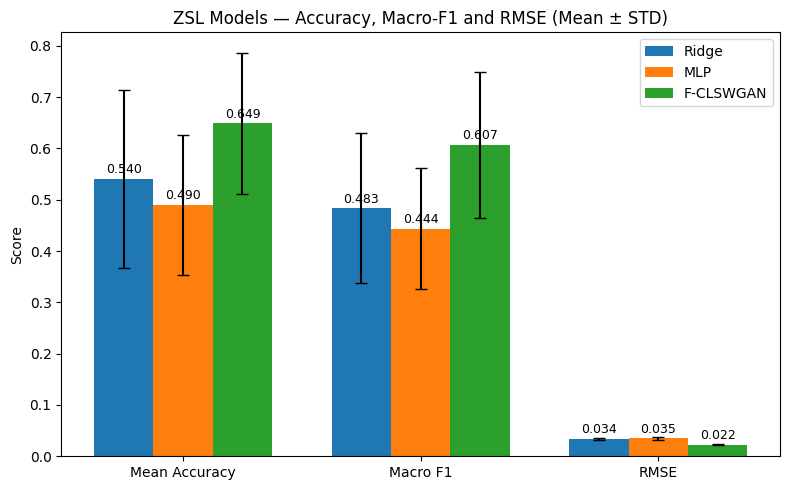

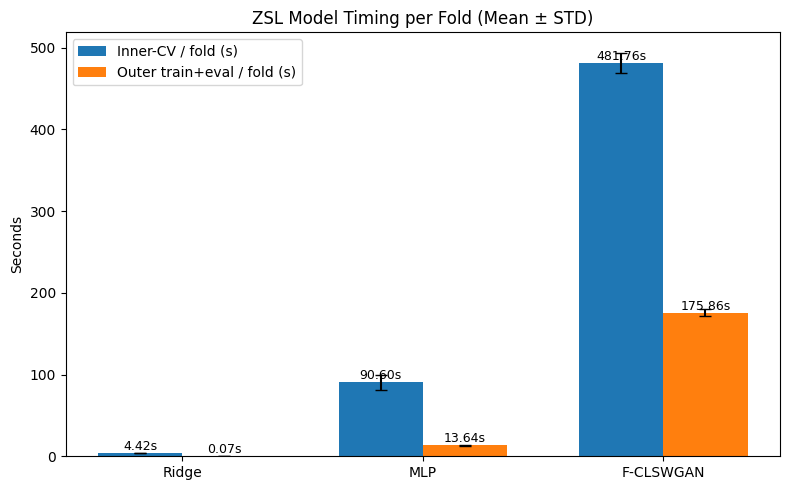

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ================= data =================
metrics = ["Mean Accuracy", "Macro F1", "RMSE"]
models = ["Ridge", "MLP", "F-CLSWGAN"]

# mean and std
values_mean = np.array([
    [0.5405, 0.4896, 0.6492],   # Accuracy
    [0.4835, 0.4437, 0.6073],   # F1
    [0.033821, 0.034955, 0.022500]  # RMSE
]).T  # 3×3 (Ridge, MLP, GAN)

values_std = np.array([
    [0.1737, 0.1359, 0.1377],
    [0.1457, 0.1184, 0.1425],
    [0.002618, 0.002342, 0.000498]
]).T

# timing data
inner_mean = np.array([4.42, 90.60, 481.76])
inner_std  = np.array([0.12, 9.19, 12.25])
outer_mean = np.array([0.07, 13.64, 175.86])
outer_std  = np.array([0.01, 0.47, 4.50])


fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(metrics))
width = 0.25
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, (model, color) in enumerate(zip(models, colors)):
    ax.bar(x + (i - 1)*width, values_mean[i], width, 
           yerr=values_std[i], capsize=4, label=model, color=color)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("ZSL Models — Accuracy, Macro-F1 and RMSE (Mean ± STD)")
ax.legend()


for i in range(len(models)):
    for j in range(len(metrics)):
        val = values_mean[i, j]
        ax.text(j + (i - 1)*width, val + (0.005 if val < 1 else 0.01),
                f"{val:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("ZSL_metrics_horizontal.png", dpi=300)
plt.show()


fig2, ax2 = plt.subplots(figsize=(8,5))
x = np.arange(len(models))
width = 0.35

b1 = ax2.bar(x - width/2, inner_mean, width, yerr=inner_std, 
             capsize=4, label="Inner-CV / fold (s)")
b2 = ax2.bar(x + width/2, outer_mean, width, yerr=outer_std, 
             capsize=4, label="Outer train+eval / fold (s)")

ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_ylabel("Seconds")
ax2.set_title("ZSL Model Timing per Fold (Mean ± STD)")
ax2.legend()


for bars, vals in [(b1, inner_mean), (b2, outer_mean)]:
    for bar, val in zip(bars, vals):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{val:.2f}s", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("ZSL_timing_with_std.png", dpi=300)
plt.show()
